# 1 Dunnhumby Cleaning, Wrangling, EDA 

## 1.1 Contents  <a id='1.1_Contents'></a>
* [1.1 Contents](#1.1_Contents)
* [1.2 Introduction](#1.2_Intro)
* [1.3 Imports](#1.3_Imports)
* [1.4 Loading Data](#1.4_Load)
* [1.5 Set Options](#1.5_Options)
* [1.6 Cleaning/Wrangling/EDA](#1.6_Clean)
    * [1.6.1 Summarizing the Data](#1.6.1)
        * [a. campaign_desc table](#a)
        * [b. campaign_table table](#b)
        * [c. causal_data table](#c)
        * [d. coupon table](#d)
        * [e. coupon_redempt table](#e)
        * [f. hh_demographics table](#f)
        * [g. product table](#g)
        * [h. transaction_data table](#h)
    * [1.6.3 Extended EDA: Demographics and Coupon Use Data](#1.6.3)
    * [1.6.4 Seasonal Data & Trends](#1.6.4)
* [1.7 Exports](#1.7)
* [1.8 Conclusions](#1.8)
* [1.9 Next Steps](#1.9)







## 1.2 Introduction <a id='1.2_Intro'></a>

The Dunnhumby Complete Journey dataset contains household level transactions over nearly 2 years from a group of 2500 households that shop at a popular retailer. My primary objective is to understand how direct marketing campaigns and household demographics impact customer spending, and to predict future customer spending trends and coupon use to build more effective marketing campaigns. 

The data was sourced from Kaggle (https://www.kaggle.com/datasets/frtgnn/dunnhumby-the-complete-journey), and consists of 8 CSV files. These tables include data on campaigns sent out to customers, what households they were sent to, where products were featured in mailers and in-store displays, which products and campaigns coupons correspond to, who redeemed these coupons and when, customer demographics, product data, and details on all transactions that took place during the time period of this study. All of the tables can be easily linked together with shared features. 

In this notebook I will clean, wrangle and perform exploratory data analysis on the data so that I can create an effective model in the next steps. 

## 1.3 Imports <a id='1.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
import pandasql as psql
from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error

## 1.4 Load <a id='1.4_Load'></a>

In [2]:
campaign_desc = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\customer behavior data\campaign_desc.csv")
campaign_table = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\customer behavior data\campaign_table.csv")
causal_data = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\customer behavior data\causal_data.csv")
coupon = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\customer behavior data\coupon.csv")
coupon_redempt = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\customer behavior data\coupon_redempt.csv")
hh_demographic = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\customer behavior data\hh_demographic.csv")
product = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\customer behavior data\product.csv")
transaction_data = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\customer behavior data\transaction_data.csv")

## 1.5 Set Options <a id='1.5_Options'></a>

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Set up my psql
pysql = lambda q: sqldf(q, globals())

## 1.6 Cleaning/Wrangling <a id='1.6_Clean'></a>

### 1.6.1 Summarizing the data <a id='1.6.1'></a>

Summary of all the dataframes:

In [4]:
# List of dataframes
dataframes = {
    'campaign_desc': campaign_desc,
    'campaign_table': campaign_table,
    'causal_data': causal_data,
    'coupon': coupon,
    'coupon_redempt': coupon_redempt,
    'hh_demographic': hh_demographic,
    'product': product,
    'transaction_data': transaction_data
}

info_df = pd.DataFrame(columns=['df_name', 'number_of_rows', 'number_of_columns', 'column_names'])

for name, df in dataframes.items():
    row = pd.DataFrame({
        'df_name': [name],
        'number_of_rows': [df.shape[0]],
        'number_of_columns': [df.shape[1]],
        'column_names': [', '.join(df.columns)]
    })
    info_df = pd.concat([info_df, row], ignore_index=True)

info_df.head(8)


df_name number_of_rows number_of_columns  \
0     campaign_desc             30                 4   
1    campaign_table           7208                 3   
2       causal_data       36786524                 5   
3            coupon         124548                 3   
4    coupon_redempt           2318                 4   
5    hh_demographic            801                 8   
6           product          92353                 7   
7  transaction_data        2595732                12   

                                                                                                                                   column_names  
0                                                                                                     DESCRIPTION, CAMPAIGN, START_DAY, END_DAY  
1                                                                                                          DESCRIPTION, household_key, CAMPAIGN  
2                                                                                                PRODUCT_ID, STORE_ID, WEEK_NO, display, mailer  
3                                                                                                              COUPON_UPC, PRODUCT_ID, CAMPAIGN  
4                                                                                                      household_key, DAY, COUPON_UPC, CAMPAIGN  
5               AGE_DESC, MARITAL_STATUS_CODE, INCOME_DESC, HOMEOWNER_DESC, HH_COMP_DESC, HOUSEHOLD_SIZE_DESC, KID_CATEGORY_DESC, household_key  
6                                         PRODUCT_ID, MANUFACTURER, DEPARTMENT, BRAND, COMMODITY_DESC, SUB_COMMODITY_DESC, CURR_SIZE_OF_PRODUCT  
7  household_key, BASKET_ID, DAY, PRODUCT_ID, QUANTITY, SALES_VALUE, STORE_ID, RETAIL_DISC, TRANS_TIME, WEEK_NO, COUPON_DISC, COUPON_MATCH_DISC

Check out heads of dataframes:

In [5]:
campaign_desc.head()

DESCRIPTION  CAMPAIGN  START_DAY  END_DAY
0       TypeB        24        659      719
1       TypeC        15        547      708
2       TypeB        25        659      691
3       TypeC        20        615      685
4       TypeB        23        646      684

In [6]:
campaign_table.head()

DESCRIPTION  household_key  CAMPAIGN
0       TypeA             17        26
1       TypeA             27        26
2       TypeA            212        26
3       TypeA            208        26
4       TypeA            192        26

In [7]:
causal_data.head().sort_values(by='display', ascending= False)

PRODUCT_ID  STORE_ID  WEEK_NO display mailer
0       26190       286       70       0      A
1       26190       288       70       0      A
2       26190       289       70       0      A
3       26190       292       70       0      A
4       26190       293       70       0      A

In [8]:
coupon.head()

COUPON_UPC  PRODUCT_ID  CAMPAIGN
0  10000089061       27160         4
1  10000089064       27754         9
2  10000089073       28897        12
3  51800009050       28919        28
4  52100000076       28929        25

In [9]:
coupon_redempt.head()

household_key  DAY   COUPON_UPC  CAMPAIGN
0              1  421  10000085364         8
1              1  421  51700010076         8
2              1  427  54200000033         8
3              1  597  10000085476        18
4              1  597  54200029176        18

In [10]:
hh_demographic.head()

AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC  \
0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   
2    25-34                   U      25-34K        Unknown     2 Adults Kids   
3    25-34                   U      75-99K      Homeowner     2 Adults Kids   
4    45-54                   B      50-74K      Homeowner     Single Female   

  HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key  
0                   2      None/Unknown              1  
1                   2      None/Unknown              7  
2                   3                 1              8  
3                   4                 2             13  
4                   1      None/Unknown             16

In [11]:
product.head()

PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND            COMMODITY_DESC  \
0       25671             2       GROCERY  National                  FRZN ICE   
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   
2       26093            69        PASTRY   Private                     BREAD   
3       26190            69       GROCERY   Private      FRUIT - SHELF STABLE   
4       26355            69       GROCERY   Private             COOKIES/CONES   

            SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
0          ICE - CRUSHED/CUBED                22 LB  
1  NO SUBCOMMODITY DESCRIPTION                       
2         BREAD:ITALIAN/FRENCH                       
3                  APPLE SAUCE                50 OZ  
4            SPECIALTY COOKIES                14 OZ

In [12]:
transaction_data.head()

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  
0       364        -0.60        1631        1          0.0                0.0  
1       364         0.00        1631        1          0.0                0.0  
2       364        -0.30        1631        1          0.0                0.0  
3       364         0.00        1631        1          0.0                0.0  
4       364        -0.39        1631        1          0.0                0.0

<b> Change all column names to lower case </b>

In [13]:
campaign_desc.columns = campaign_desc.columns.str.lower()
campaign_table.columns = campaign_table.columns.str.lower()
causal_data.columns = causal_data.columns.str.lower()
coupon.columns = coupon.columns.str.lower()
coupon_redempt.columns = coupon_redempt.columns.str.lower()
hh_demographic.columns = hh_demographic.columns.str.lower()
product.columns = product.columns.str.lower()
transaction_data.columns = transaction_data.columns.str.lower()

## 1.6.2 Diving in to the Tables <a id='1.6.1'></a>
Here I am taking a closer look at all 8 tables, cleaning and wrangling them as needed, and doing preliminary EDA.

### a. campaign_desc table <a id='a'></a>

In [14]:
# add duration_days column to campaign_desc
campaign_desc['duration_days']= campaign_desc['end_day']-campaign_desc['start_day']

campaign_desc.head()

description  campaign  start_day  end_day  duration_days
0       TypeB        24        659      719             60
1       TypeC        15        547      708            161
2       TypeB        25        659      691             32
3       TypeC        20        615      685             70
4       TypeB        23        646      684             38

In [15]:
# summary stats

campaign_desc.describe().round(2)

campaign  start_day  end_day  duration_days
count     30.00      30.00    30.00          30.00
mean      15.50     463.87   510.47          46.60
std        8.80     134.49   137.73          24.86
min        1.00     224.00   264.00          32.00
25%        8.25     360.00   405.75          32.00
50%       15.50     470.00   502.00          37.50
75%       22.75     584.00   640.25          54.50
max       30.00     659.00   719.00         161.00

In [16]:
# How many unique campaign types are there?
campaign_desc.groupby('description')['campaign'].sum()

description
TypeA     95
TypeB    285
TypeC     85
Name: campaign, dtype: int64

So there are 3 broad campaign types(A,B,C). A has 95 campaigns, B has 285 campaigns, and C has 85 campaigns. The median duration of a campaign is 37.5 days

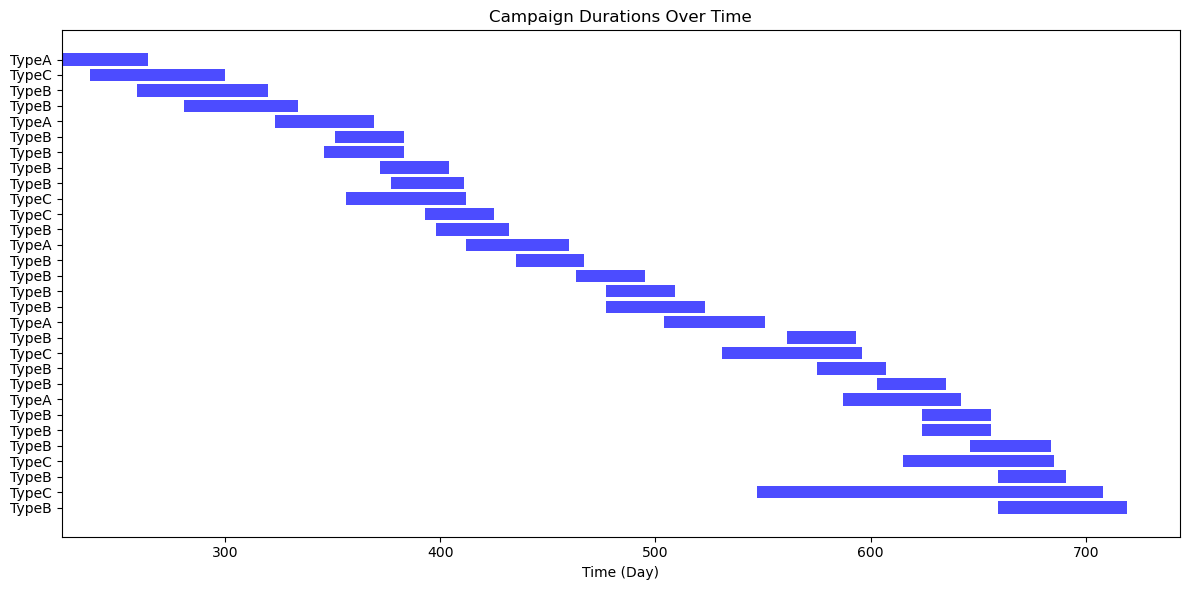

In [17]:
# What do the campaign durations look like over time? In the below plot we can see which campaigns are running when

fig, ax = plt.subplots(figsize=(12, 6))

for i, row in campaign_desc.iterrows():
    ax.barh(i, row["duration_days"], left=row["start_day"],
            color='b', alpha=0.7, label=row["description"])

ax.set_yticks(range(len(campaign_desc)))
ax.set_yticklabels(campaign_desc["description"])
ax.set_xlabel('Time (Day)')
ax.set_title('Campaign Durations Over Time')

plt.tight_layout()
plt.show();



In [18]:
# Which campaigns run under 50 days?

camp_under_50=pysql("SELECT campaign, description, duration_days FROM campaign_desc WHERE duration_days < 50 ORDER BY description;")
camp_under_50

campaign description  duration_days
0         13       TypeA             47
1          8       TypeA             48
2         30       TypeA             46
3         26       TypeA             40
4         25       TypeB             32
5         23       TypeB             38
6         21       TypeB             32
7         22       TypeB             32
8         19       TypeB             32
9         17       TypeB             32
10        16       TypeB             32
11        11       TypeB             46
12        12       TypeB             32
13        10       TypeB             32
14         9       TypeB             32
15         7       TypeB             34
16         5       TypeB             34
17         4       TypeB             32
18         1       TypeB             37
19         2       TypeB             32
20         6       TypeC             32

In [19]:
# Which campaigns run 50-80 days?
query = """
SELECT campaign, description, duration_days 
FROM campaign_desc 
WHERE duration_days BETWEEN 50 AND 80 
ORDER BY description;
"""
camp_50_80=pysql(query)
camp_50_80

campaign description  duration_days
0        18       TypeA             55
1        24       TypeB             60
2        29       TypeB             53
3        28       TypeB             61
4        20       TypeC             70
5        14       TypeC             65
6         3       TypeC             56
7        27       TypeC             63

In [20]:
# Which campaigns run 80-100 days?

camp_80_100=pysql("SELECT campaign, description, duration_days FROM campaign_desc WHERE duration_days BETWEEN 81 AND 100 ORDER BY description;")
camp_80_100

Empty DataFrame
Columns: [campaign, description, duration_days]
Index: []

In [21]:
# Which campaigns run 100+ days?

camp_100=pysql("SELECT campaign, description, duration_days FROM campaign_desc WHERE duration_days > 100 ORDER BY description;")
camp_100

campaign description  duration_days
0        15       TypeC            161

<b>Only campaign 15 is over 70 days, and it is 161 days! The rest are mostly between 32-50 days long. </b>



### b. campaign_table table <a id='b'></a>
This is which households are sent which campaigns

In [22]:
# How many households were sent each campaign
campaign_counts = campaign_table.groupby('campaign')['household_key'].nunique()
campaign_counts

campaign
1       13
2       48
3       12
4       81
5      166
6       65
7      198
8     1076
9      176
10     123
11     214
12     170
13    1077
14     224
15      17
16     188
17     202
18    1133
19     130
20     244
21      65
22     276
23     183
24     100
25     187
26     332
27      12
28      17
29     118
30     361
Name: household_key, dtype: int64

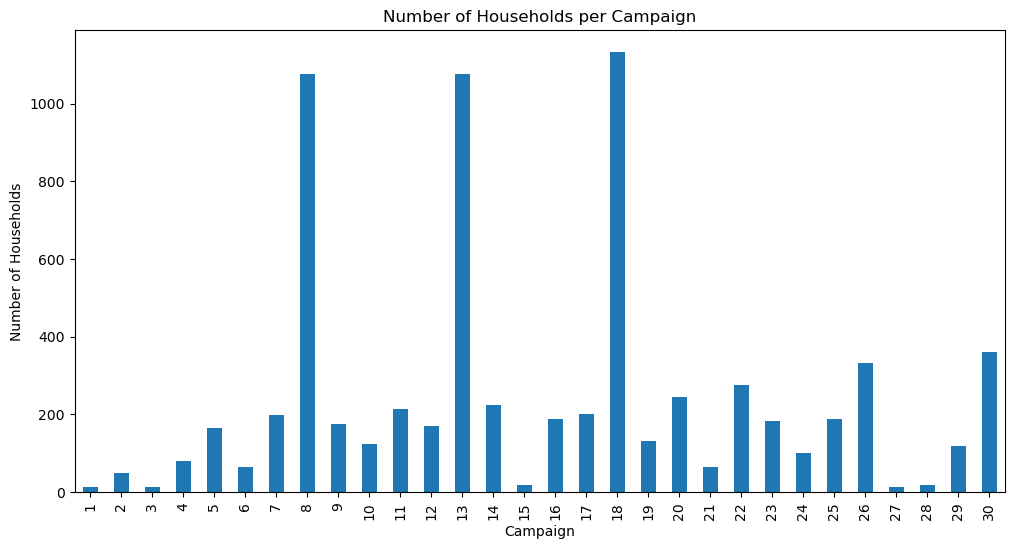

In [23]:
# Looking at a plot of how many households were sent each campaign

plt.figure(figsize=(12, 6))
campaign_counts.plot(kind='bar')
plt.xlabel('Campaign')
plt.ylabel('Number of Households')
plt.title('Number of Households per Campaign')
plt.xticks(rotation=90)
plt.show()

8,13,18 were all sent to the most households. I'm curious about the durations

In [24]:
query = pysql("SELECT DISTINCT campaign_desc.campaign, campaign_desc.duration_days, campaign_desc.description FROM campaign_desc INNER JOIN campaign_table ON campaign_desc.campaign = campaign_table.campaign WHERE campaign_desc.campaign IN (8, 13, 18)")
query

campaign  duration_days description
0        18             55       TypeA
1        13             47       TypeA
2         8             48       TypeA

These were all type A campaigns and with similar durations. 

### c. causal_data table <a id='c'></a>

This table signifies whether a given product was featured in the weekly mailer or was part of an in store display

Display meaning: 0 - not on display 1 - store front 2 - store rear 3 - front end cap 4 - mid aisle end cap 5 - rear end cap 6 - side aisle end cap 7 - in-aisle 9- secondary location display A - in shelf

Mailer meaning: 0 - not on ad A - interior page feature C - interior page line item D - front page feature F - back page feature H - wrap front feature J - Wrap interior coupon L - Wrap back feature P - interior page coupon X - free on interior page Z - free on front page, back page or wrap

In [25]:
causal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36786524 entries, 0 to 36786523
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   product_id  int64 
 1   store_id    int64 
 2   week_no     int64 
 3   display     object
 4   mailer      object
dtypes: int64(3), object(2)
memory usage: 1.4+ GB


In [26]:
n_stores = causal_data.store_id.nunique()
n_products = causal_data.product_id.nunique()
n_weeks = causal_data.week_no.nunique()
print('n_stores:',n_stores)
print('n_products: ', n_products)
print('n_weeks: ', n_weeks)

n_stores: 115
n_products:  68377
n_weeks:  93


In [27]:
# check data types
causal_data.dtypes

product_id     int64
store_id       int64
week_no        int64
display       object
mailer        object
dtype: object

In [28]:
# How are the display and mailer data distributed? There are millions of rows. 

causal_data_counts = causal_data['display'].value_counts()
causal_data_counts

0    21038745
9     2699467
5     2575289
7     2362118
3     2073738
6     1816021
2     1812840
1     1102141
A      713180
4      592985
Name: display, dtype: int64

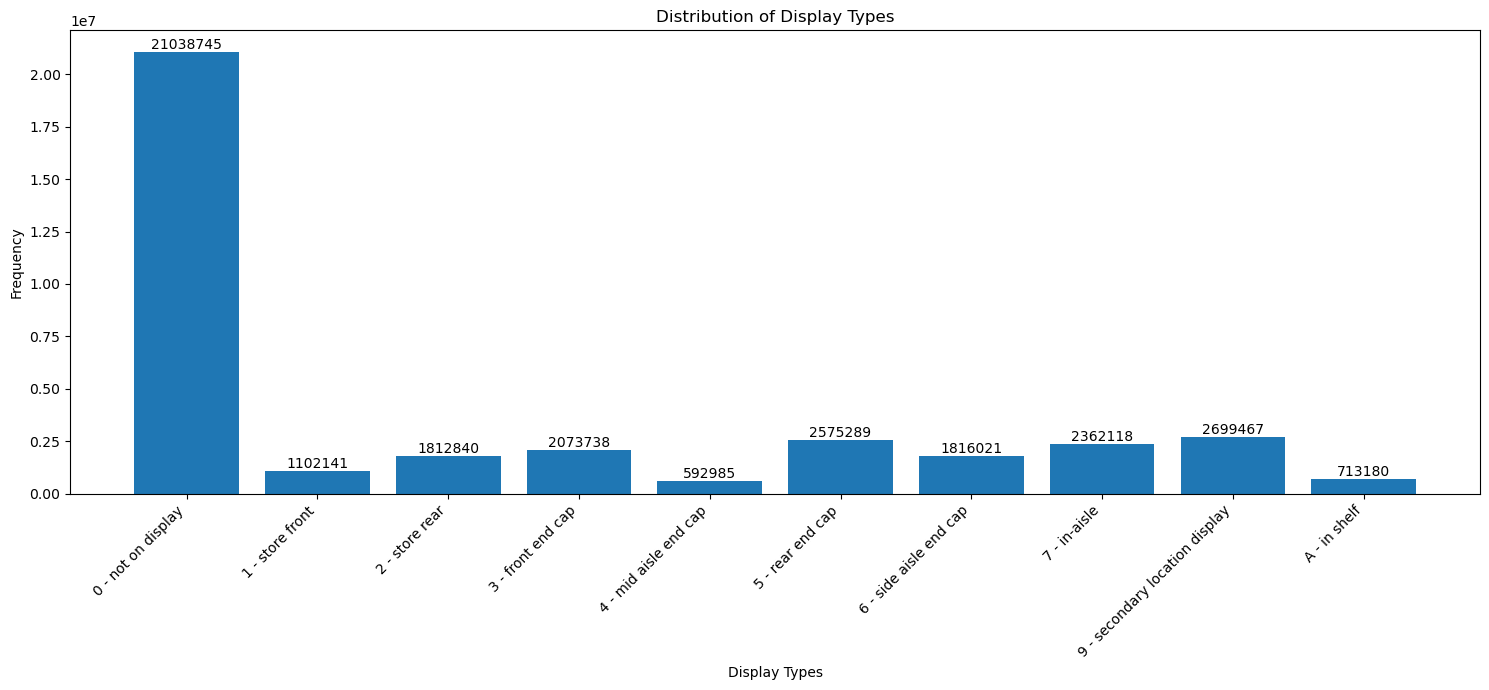

In [29]:
# Create a visual of this. 

# Sort the index to make the plot easier to interpret
causal_data_counts = causal_data_counts.sort_index()

labels = ["0 - not on display", "1 - store front", "2 - store rear", "3 - front end cap",
          "4 - mid aisle end cap", "5 - rear end cap", "6 - side aisle end cap",
          "7 - in-aisle", "9 - secondary location display", "A - in shelf"]

plt.figure(figsize=(15, 7))
plt.bar(causal_data_counts.index.astype(str), causal_data_counts.values)
plt.xlabel('Display Types')
plt.ylabel('Frequency')
plt.title('Distribution of Display Types')
plt.xticks(ticks=range(len(causal_data_counts.index)), labels=labels, rotation=45, ha="right", fontsize=10)

# show value counts
for i, v in enumerate(causal_data_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show();

In [30]:
# do the same thing with 'mailer':

causal_data_mailer_counts = causal_data['mailer'].value_counts()
causal_data_mailer_counts

A    17106789
0    11534183
D     4467453
H     1560395
F     1077549
J      306924
L      301327
C      291059
X      120823
Z       19453
P         569
Name: mailer, dtype: int64

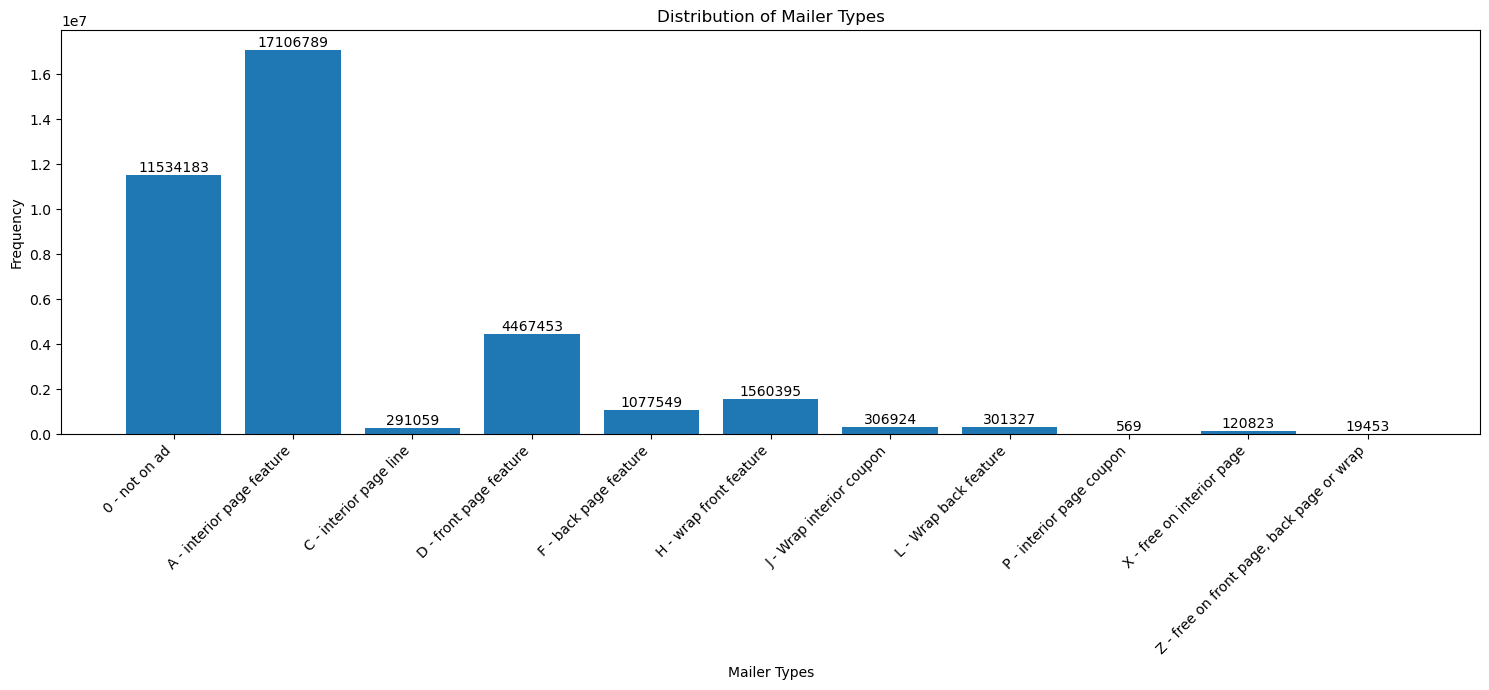

In [31]:
causal_data_mailer_counts = causal_data_mailer_counts.sort_index()

labels = ["0 - not on ad", "A - interior page feature", "C - interior page line", "D - front page feature",
          "F - back page feature", "H - wrap front feature", "J - Wrap interior coupon",
          "L - Wrap back feature", "P - interior page coupon", "X - free on interior page"," Z - free on front page, back page or wrap"]

plt.figure(figsize=(15, 7))
plt.bar(causal_data_mailer_counts.index.astype(str), causal_data_mailer_counts.values)
plt.xlabel('Mailer Types')
plt.ylabel('Frequency')
plt.title('Distribution of Mailer Types')
plt.xticks(ticks=range(len(causal_data_mailer_counts.index)), labels=labels, rotation=45, ha="right", fontsize=10)

# show value counts
for i, v in enumerate(causal_data_mailer_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show();

Most products are not on display, and those that are mostly have roughly even distribution among display types. Most mailer types are an interior page feature, not on ad, or front page feature. 

### d. coupon table <a id='db'></a>

All the coupons sent to customers as a part of a campaign, as well as the products for which each coupon is redeemable. Some coupons are redeemable for multiple products. 

In [32]:
coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124548 entries, 0 to 124547
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   coupon_upc  124548 non-null  int64
 1   product_id  124548 non-null  int64
 2   campaign    124548 non-null  int64
dtypes: int64(3)
memory usage: 2.9 MB


In [33]:
# How many unique coupons are there?
coupon.coupon_upc.nunique()

1135

In [34]:
# how many products does each coupon cover? 

query = """
SELECT coupon.coupon_upc, COUNT(DISTINCT coupon.product_id) as num_products
from coupon
JOIN product ON coupon.product_id = product.product_id
GROUP BY coupon.coupon_upc
HAVING num_products > 1
ORDER BY num_products DESC;
"""
num_prod_by_coupon = psql.sqldf(query, locals())
num_prod_by_coupon

coupon_upc  num_products
0     10000085478         14477
1     10000085428         14367
2     10000085427          5713
3     10000085477          5686
4     10000085479          5474
...           ...           ...
1083  10000089035             2
1084  10000089032             2
1085  10000089014             2
1086  10000089008             2
1087  10000085433             2

[1088 rows x 2 columns]

In [35]:
# how many departments does each coupon cover?

query = """
SELECT coupon.coupon_upc, COUNT(DISTINCT coupon.product_id) AS num_products, COUNT(DISTINCT product.department) AS num_dep
FROM coupon
JOIN product ON coupon.product_id = product.product_id
GROUP BY coupon.coupon_upc
HAVING num_products > 1
ORDER BY num_dep DESC;
"""

num_dep_by_coupon = psql.sqldf(query, locals())

num_dep_by_coupon

coupon_upc  num_products  num_dep
0     10000085475          4294       19
1     10000085425          4189       19
2     10000085362          3580       17
3     10000085429          5423       12
4     10000085479          5474       11
...           ...           ...      ...
1083  10000085368             4        1
1084  10000085320             7        1
1085  10000085319            28        1
1086  10000085207            17        1
1087  10000085190             4        1

[1088 rows x 3 columns]

So 1088 coupons out of 1135 are valid for multiple products. The most products that a coupon is valid for is 14477, but the most number of departments a coupon is valid for is 19. 

### e. coupon_redempt table <a id='e'></a>

Coupons that each household redeemed

In [36]:
coupon_redempt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   household_key  2318 non-null   int64
 1   day            2318 non-null   int64
 2   coupon_upc     2318 non-null   int64
 3   campaign       2318 non-null   int64
dtypes: int64(4)
memory usage: 72.6 KB


In [37]:
# How many coupons did each household redeem each day?
query = """
SELECT household_key, day, COUNT(coupon_upc) AS num_coupons, COUNT(DISTINCT campaign) AS num_campaigns
FROM coupon_redempt
GROUP BY household_key
ORDER BY num_coupons DESC;

"""

result = psql.sqldf(query, locals())
result.head(10)


household_key  day  num_coupons  num_campaigns
0            367  232           35              9
1            256  243           33             10
2             67  431           33              7
3           1823  424           30              6
4            931  420           29              3
5           2489  357           28              6
6           1591  420           28              4
7            979  237           28              8
8           1726  244           27              6
9            574  417           25              6

### f. hh_demographic table <a id='f'></a>

Demographics of 801 of the households

In [38]:
hh_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [39]:
# Change marital status categories away from a code, reorder columns

hh_demographic['marital_status'] = hh_demographic['marital_status_code'].replace({'A': 'Married', 'B': 'Single', 'U': 'Unknown'})
hh_demographic.drop(columns='marital_status')
hh_demographic = hh_demographic[['age_desc','marital_status','income_desc','homeowner_desc','hh_comp_desc','household_size_desc','kid_category_desc','household_key']]

hh_demographic.head()


age_desc marital_status income_desc homeowner_desc      hh_comp_desc  \
0      65+        Married      35-49K      Homeowner  2 Adults No Kids   
1    45-54        Married      50-74K      Homeowner  2 Adults No Kids   
2    25-34        Unknown      25-34K        Unknown     2 Adults Kids   
3    25-34        Unknown      75-99K      Homeowner     2 Adults Kids   
4    45-54         Single      50-74K      Homeowner     Single Female   

  household_size_desc kid_category_desc  household_key  
0                   2      None/Unknown              1  
1                   2      None/Unknown              7  
2                   3                 1              8  
3                   4                 2             13  
4                   1      None/Unknown             16

In [40]:
# Change datatypes to category where applicable

for col in hh_demographic.columns:
    if hh_demographic[col].dtype == 'object':
        hh_demographic.loc[:, col] = hh_demographic.loc[:, col].astype('category')

        
hh_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age_desc             801 non-null    category
 1   marital_status       801 non-null    category
 2   income_desc          801 non-null    category
 3   homeowner_desc       801 non-null    category
 4   hh_comp_desc         801 non-null    category
 5   household_size_desc  801 non-null    category
 6   kid_category_desc    801 non-null    category
 7   household_key        801 non-null    int64   
dtypes: category(7), int64(1)
memory usage: 13.4 KB


C:\Users\leann\AppData\Local\Temp\ipykernel_6664\785569028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh_demographic.loc[:, col] = hh_demographic.loc[:, col].astype('category')
C:\Users\leann\AppData\Local\Temp\ipykernel_6664\785569028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh_demographic.loc[:, col] = hh_demographic.loc[:, col].astype('category')
C:\Users\leann\AppData\Local\Temp\ipykernel_6664\785569028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [41]:
# check for missing data
hh_demographic.isna().sum().any()

False

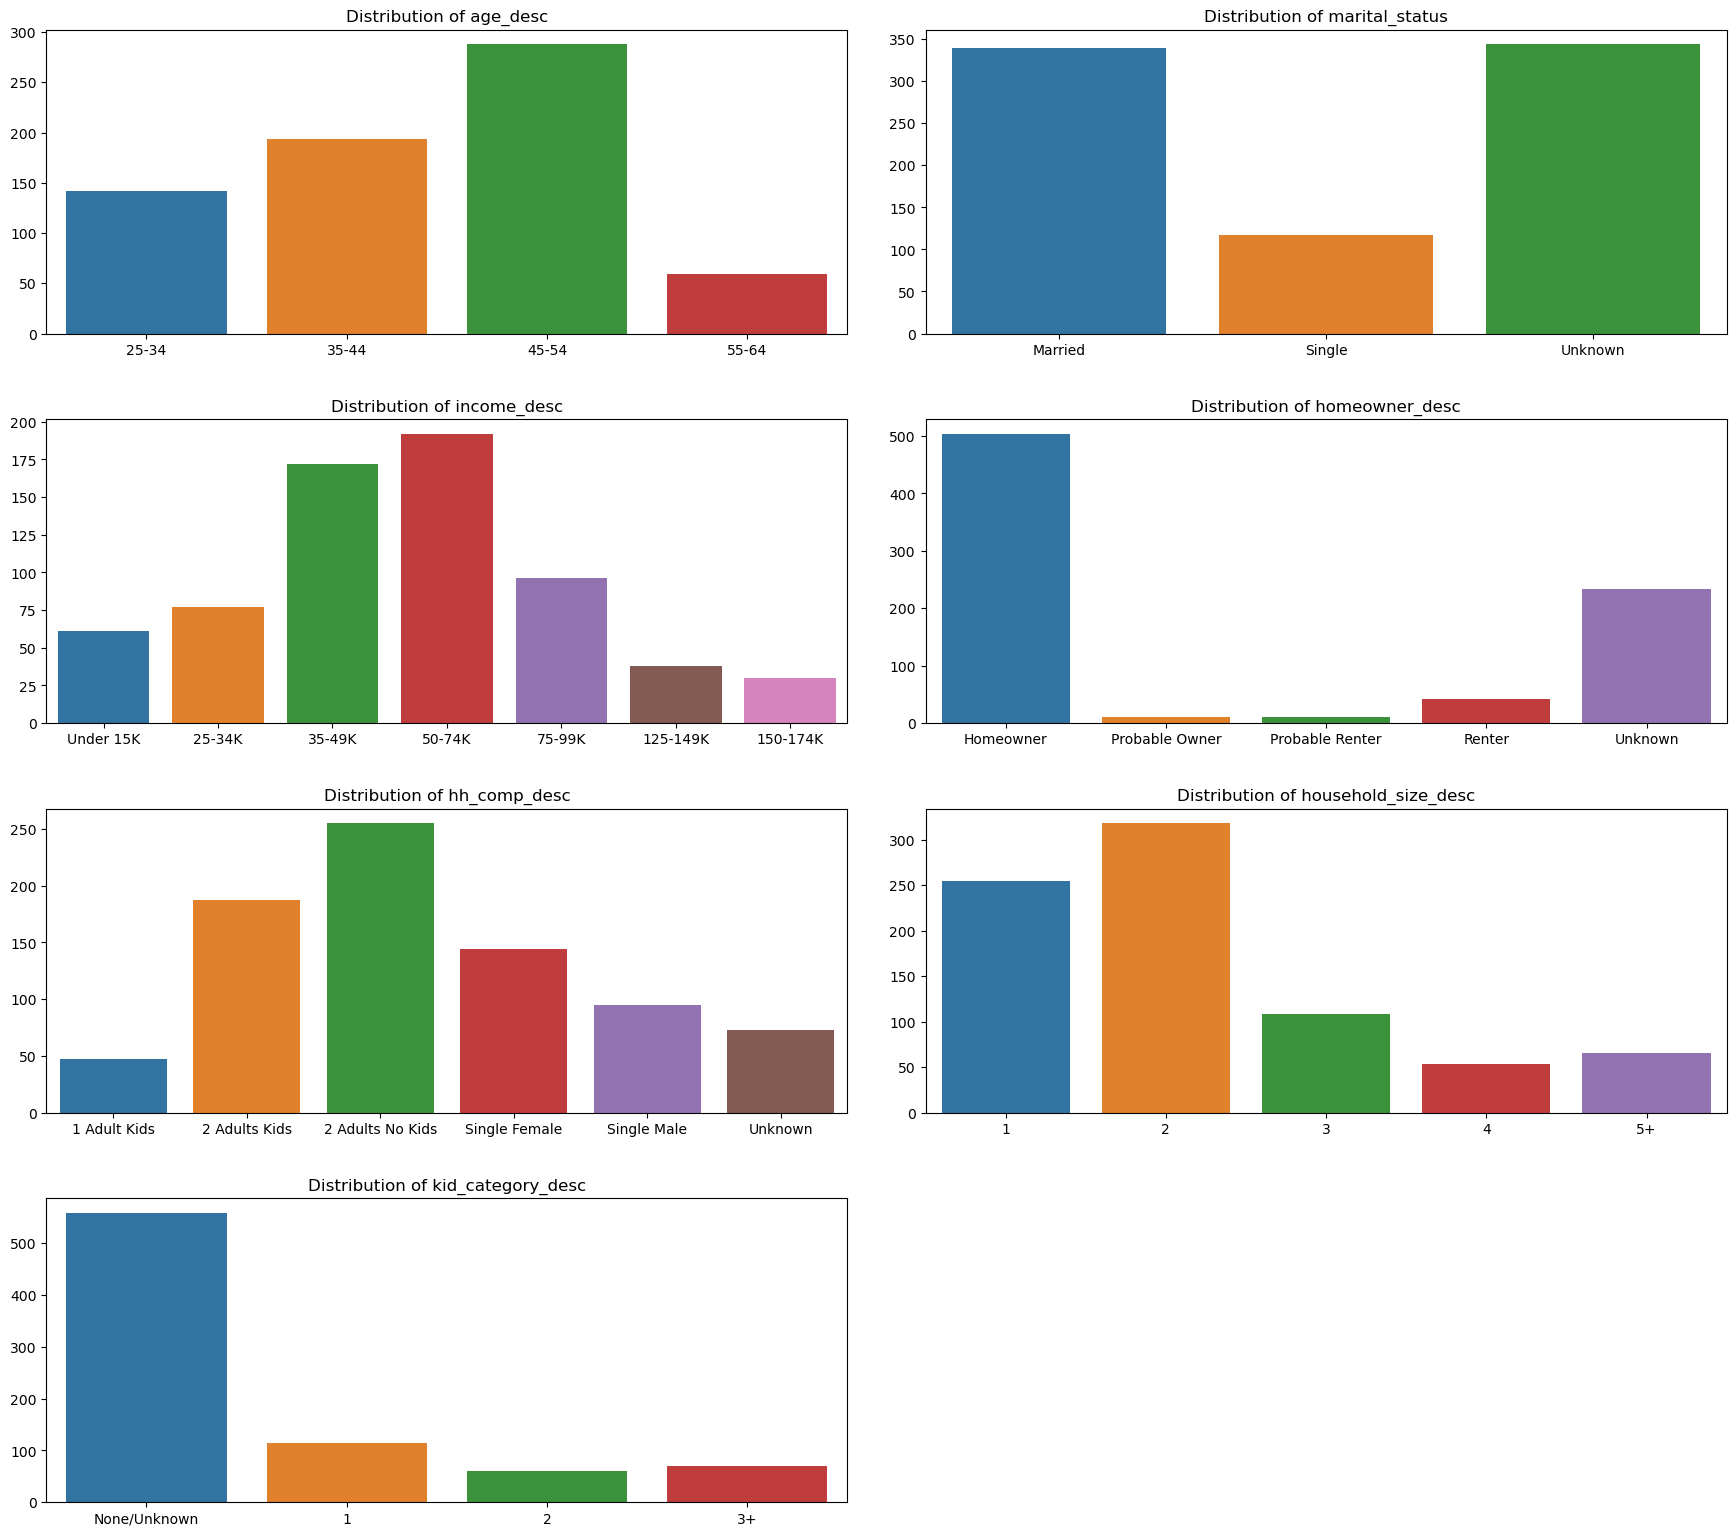

In [42]:
# I'd like to see distributions of our demographics

age_desc_order = ['25-34', '35-44', '45-54', '55-64']
income_desc_order = ['Under 15K', '25-34K', '35-49K', '50-74K', '75-99K', '125-149K', '150-174K']
household_size_desc_order = ['1', '2', '3', '4', '5+']
kid_category_desc_order = ['None/Unknown', '1', '2', '3+']

# Creating the subplots
fig, ax = plt.subplots(4, 2, figsize=(18, 16))

# Create a barplot for each column
for idx, col in enumerate(hh_demographic.columns):
    sns.barplot(x=hh_demographic[col].value_counts().index, 
                y=hh_demographic[col].value_counts().values, 
                ax=ax[idx // 2, idx % 2], 
                order=eval(f"{col}_order") if col in ['age_desc', 'income_desc', 'household_size_desc', 'kid_category_desc'] else None)
    ax[idx // 2, idx % 2].set_title(f'Distribution of {col}')

fig.delaxes(ax[3, 1])

plt.tight_layout(pad=3.0)
plt.show()


In [43]:
# Join together our demographics and coupon count data, 
# so we know how many coupons each household redeemed during the 2 year period
query = """
SELECT h.*, COUNT(c.coupon_upc) as coupon_count
FROM hh_demographic AS h
JOIN coupon_redempt AS c 
ON h.household_key = c.household_key
GROUP BY h.household_key
ORDER BY coupon_count DESC;
"""

demographics_coupon_count = psql.sqldf(query, locals())
demographics_coupon_count.head(20)

age_desc marital_status income_desc  homeowner_desc      hh_comp_desc  \
0     55-64        Married      50-74K       Homeowner  2 Adults No Kids   
1     25-34        Unknown      50-74K       Homeowner  2 Adults No Kids   
2     45-54        Married   Under 15K       Homeowner     2 Adults Kids   
3     45-54        Married      75-99K       Homeowner  2 Adults No Kids   
4     35-44        Married      50-74K       Homeowner  2 Adults No Kids   
5     25-34        Unknown      25-34K         Unknown     Single Female   
6     35-44         Single      35-49K       Homeowner      1 Adult Kids   
7     55-64        Unknown      75-99K       Homeowner     Single Female   
8     35-44        Married      75-99K       Homeowner     2 Adults Kids   
9     45-54        Married      75-99K       Homeowner  2 Adults No Kids   
10    35-44        Married      25-34K       Homeowner     2 Adults Kids   
11    45-54        Married      50-74K       Homeowner     2 Adults Kids   
12    25-34        Married      50-74K       Homeowner     2 Adults Kids   
13    35-44        Unknown    150-174K  Probable Owner     Single Female   
14    35-44        Married      50-74K       Homeowner     2 Adults Kids   
15    45-54        Married    125-149K       Homeowner     2 Adults Kids   
16    35-44        Married    150-174K       Homeowner  2 Adults No Kids   
17    25-34        Unknown      75-99K       Homeowner     2 Adults Kids   
18    45-54        Unknown   Under 15K         Unknown       Single Male   
19    25-34        Married      50-74K       Homeowner     2 Adults Kids   

   household_size_desc kid_category_desc  household_key  coupon_count  
0                    2      None/Unknown            367            35  
1                    2      None/Unknown            256            33  
2                   5+                3+             67            33  
3                    2      None/Unknown           1823            30  
4                    2      None/Unknown           2489            28  
5                    1      None/Unknown           1591            28  
6                    2                 1            979            28  
7                    1      None/Unknown           1726            27  
8                    3                 1            574            25  
9                    2      None/Unknown             22            25  
10                   3                 1           2400            23  
11                   3                 1           2007            23  
12                   4                 2            889            23  
13                   1      None/Unknown            389            23  
14                  5+                3+            588            22  
15                   3                 1           1453            21  
16                   2      None/Unknown           1197            21  
17                   4                 2             13            21  
18                   1      None/Unknown           2200            20  
19                   4                 2           2124            20

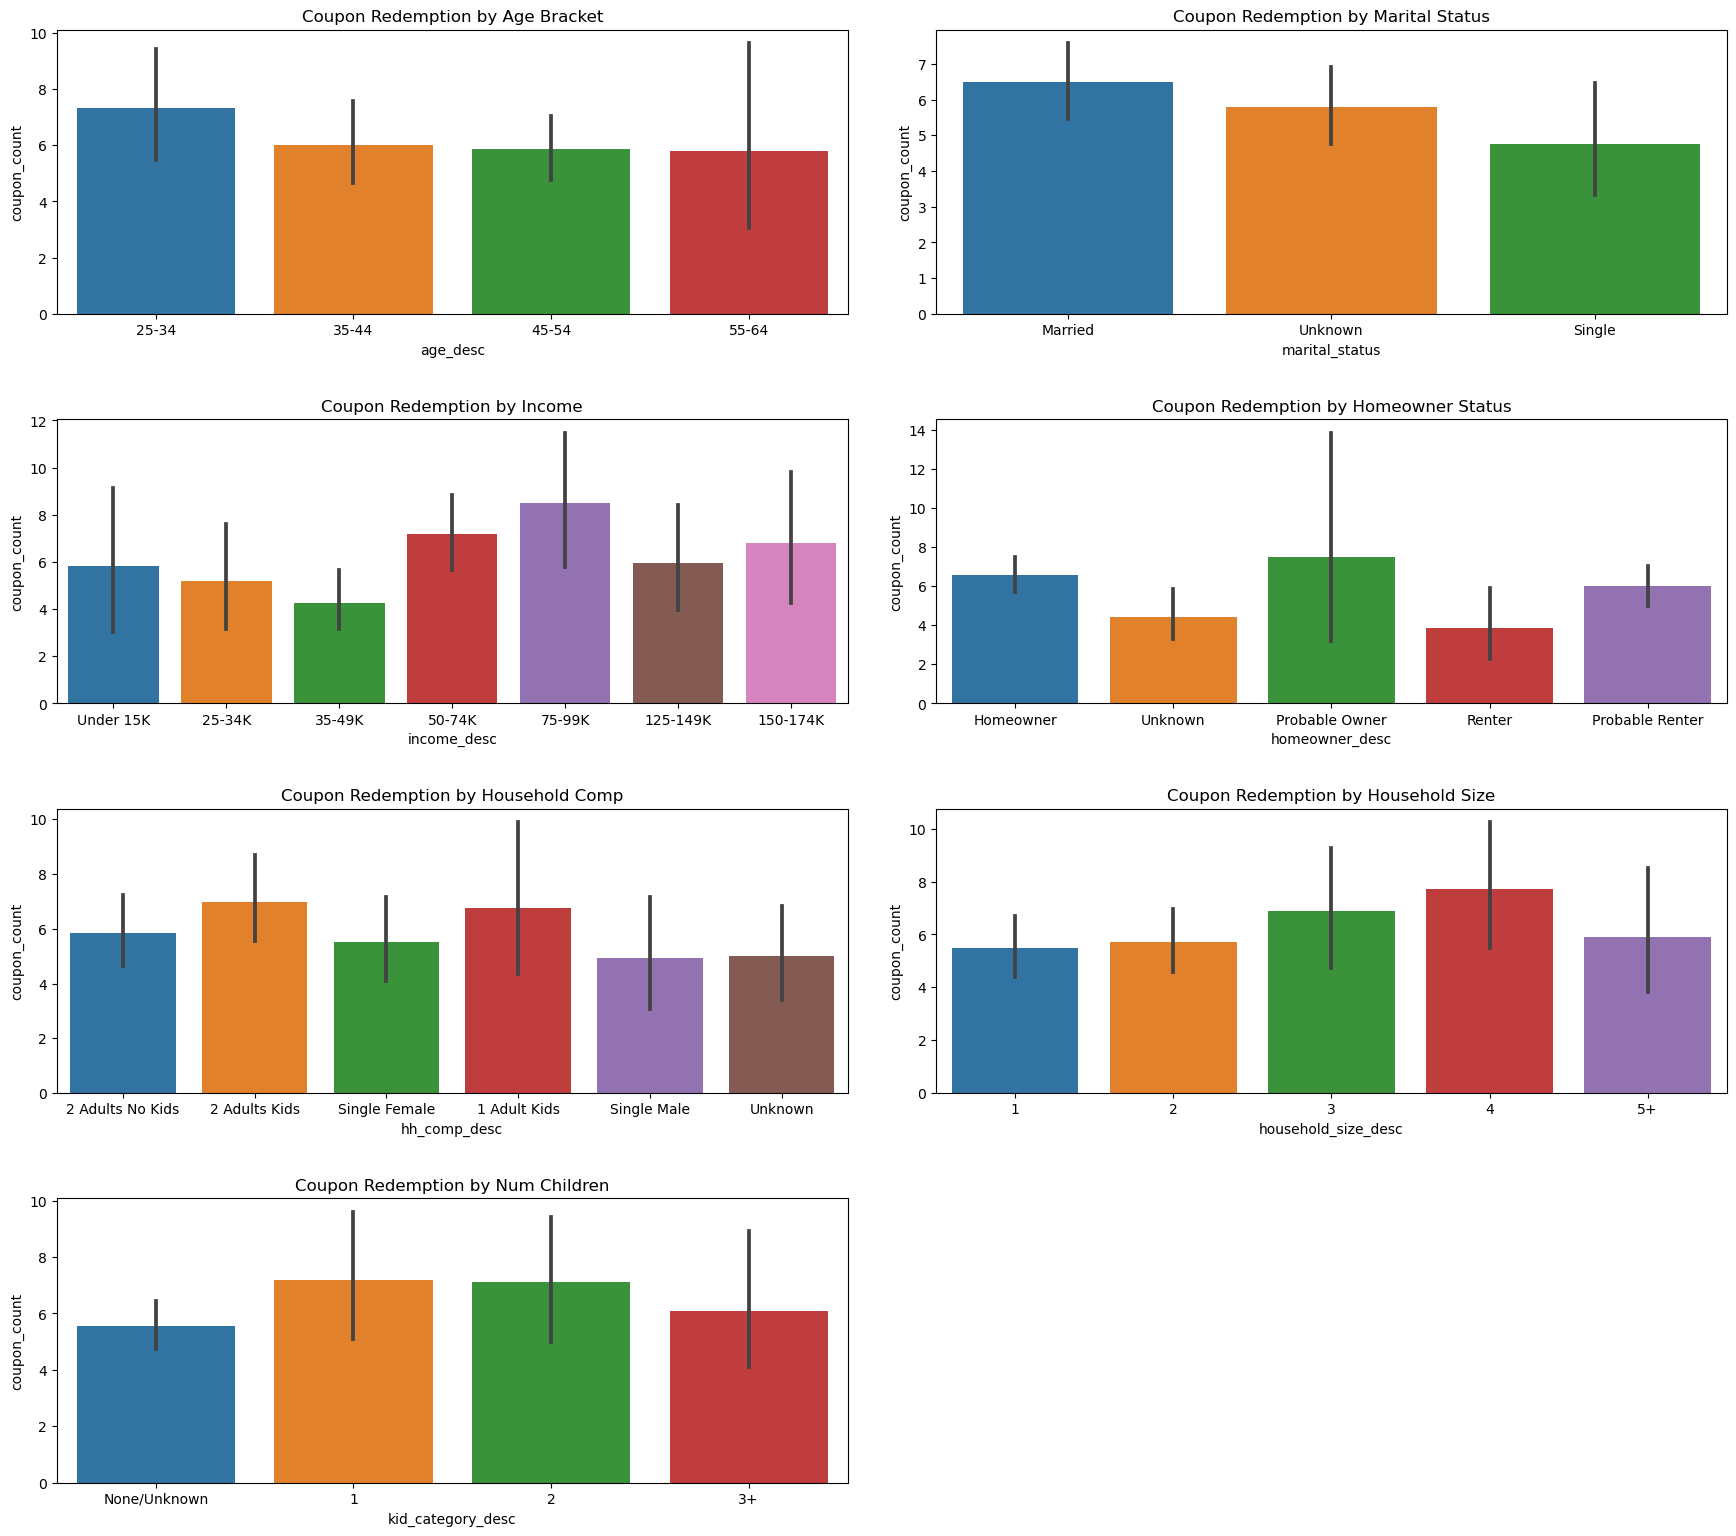

In [44]:
# Look at coupon redemption for each of the demographics categories

age_order = ['25-34', '35-44', '45-54', '55-64']
income_order = ['Under 15K', '25-34K', '35-49K', '50-74K', '75-99K', '125-149K', '150-174K']
household_size_order = ['1', '2', '3', '4', '5+']
kid_category_order = ['None/Unknown', '1', '2', '3+']


fig, ax = plt.subplots(4,2, figsize=(18,16))
sns.barplot(x='age_desc', y='coupon_count', data=demographics_coupon_count, ax=ax[0, 0], order=age_order).set(title='Coupon Redemption by Age Bracket')
sns.barplot(x='marital_status', y='coupon_count', data=demographics_coupon_count, ax=ax[0, 1]).set(title='Coupon Redemption by Marital Status')
sns.barplot(x='income_desc', y='coupon_count', data=demographics_coupon_count, ax=ax[1, 0], order=income_order).set(title='Coupon Redemption by Income')
sns.barplot(x='homeowner_desc', y='coupon_count', data=demographics_coupon_count, ax=ax[1, 1]).set(title='Coupon Redemption by Homeowner Status')
sns.barplot(x='hh_comp_desc', y='coupon_count', data=demographics_coupon_count, ax=ax[2, 0]).set(title='Coupon Redemption by Household Comp')
sns.barplot(x='household_size_desc', y='coupon_count', data=demographics_coupon_count, ax=ax[2, 1], order=household_size_order).set(title='Coupon Redemption by Household Size')
sns.barplot(x='kid_category_desc', y='coupon_count', data=demographics_coupon_count, ax=ax[3, 0], order=kid_category_order).set(title='Coupon Redemption by Num Children')

fig.delaxes(ax[3, 1])
plt.tight_layout(pad=3.0)
plt.show;

<b>I'd like to see how coupons are redeemed according to the proportion of that demographic. </b> This is important, as it tells us which groups are the most likely to redeem a coupon, regardless of how many coupons were sent out.

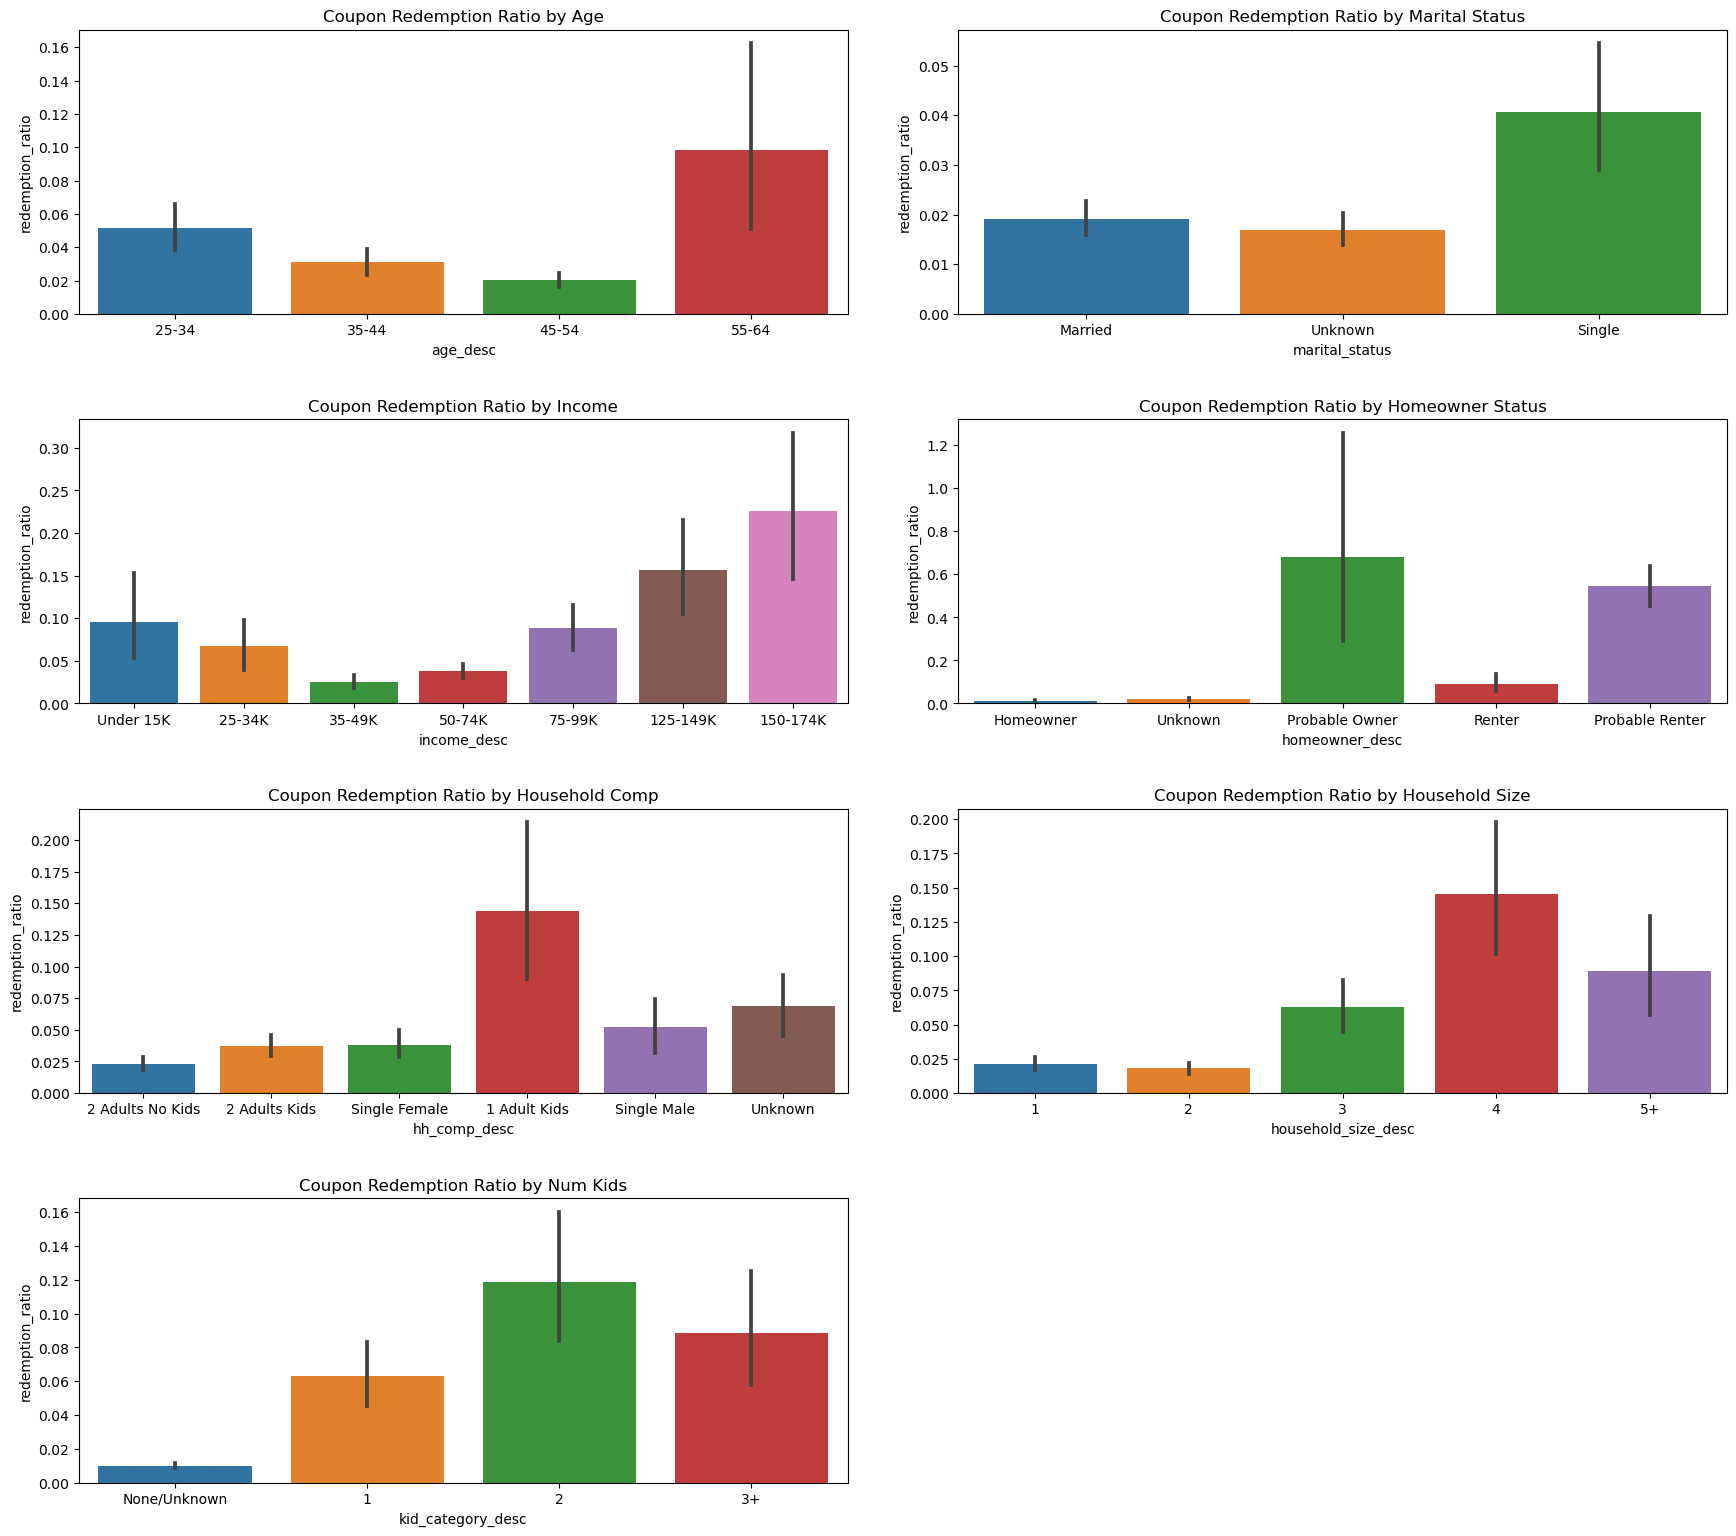

In [45]:
fig, ax = plt.subplots(4, 2, figsize=(18, 16))

# Plot for age_desc
total_counts_age = hh_demographic['age_desc'].value_counts().reset_index()
total_counts_age.columns = ['age_desc', 'total_people']
merged_df_age = pd.merge(demographics_coupon_count, total_counts_age, on='age_desc')
merged_df_age['redemption_ratio'] = merged_df_age['coupon_count'] / merged_df_age['total_people']
sns.barplot(x='age_desc', y='redemption_ratio', data=merged_df_age, ax=ax[0, 0], order=age_order).set(title='Coupon Redemption Ratio by Age')

# Plot for marital_status
total_counts_marital = hh_demographic['marital_status'].value_counts().reset_index()
total_counts_marital.columns = ['marital_status', 'total_people']
merged_df_marital = pd.merge(demographics_coupon_count, total_counts_marital, on='marital_status')
merged_df_marital['redemption_ratio'] = merged_df_marital['coupon_count'] / merged_df_marital['total_people']
sns.barplot(x='marital_status', y='redemption_ratio', data=merged_df_marital, ax=ax[0, 1]).set(title='Coupon Redemption Ratio by Marital Status')

# Plot for income_desc
total_counts_income = hh_demographic['income_desc'].value_counts().reset_index()
total_counts_income.columns = ['income_desc', 'total_people']
merged_df_income = pd.merge(demographics_coupon_count, total_counts_income, on='income_desc')
merged_df_income['redemption_ratio'] = merged_df_income['coupon_count'] / merged_df_income['total_people']
sns.barplot(x='income_desc', y='redemption_ratio', data=merged_df_income, ax=ax[1, 0], order=income_order).set(title='Coupon Redemption Ratio by Income')

# Plot for homeowner_desc
total_counts_homeowner = hh_demographic['homeowner_desc'].value_counts().reset_index()
total_counts_homeowner.columns = ['homeowner_desc', 'total_people']
merged_df_homeowner = pd.merge(demographics_coupon_count, total_counts_homeowner, on='homeowner_desc')
merged_df_homeowner['redemption_ratio'] = merged_df_homeowner['coupon_count'] / merged_df_homeowner['total_people']
sns.barplot(x='homeowner_desc', y='redemption_ratio', data=merged_df_homeowner, ax=ax[1, 1]).set(title='Coupon Redemption Ratio by Homeowner Status')

# Plot for hh_comp_desc
total_counts_hh_comp = hh_demographic['hh_comp_desc'].value_counts().reset_index()
total_counts_hh_comp.columns = ['hh_comp_desc', 'total_people']
merged_df_hh_comp = pd.merge(demographics_coupon_count, total_counts_hh_comp, on='hh_comp_desc')
merged_df_hh_comp['redemption_ratio'] = merged_df_hh_comp['coupon_count'] / merged_df_hh_comp['total_people']
sns.barplot(x='hh_comp_desc', y='redemption_ratio', data=merged_df_hh_comp, ax=ax[2, 0]).set(title='Coupon Redemption Ratio by Household Comp')
plt.tight_layout(pad=3.0)

# Plot for household_size_desc
total_counts_household_size_desc = hh_demographic['household_size_desc'].value_counts().reset_index()
total_counts_household_size_desc.columns = ['household_size_desc', 'total_people']
merged_df_household_size_desc = pd.merge(demographics_coupon_count, total_counts_household_size_desc, on='household_size_desc')
merged_df_household_size_desc['redemption_ratio'] = merged_df_household_size_desc['coupon_count'] / merged_df_household_size_desc['total_people']
sns.barplot(x='household_size_desc', y='redemption_ratio', data=merged_df_household_size_desc, ax=ax[2, 1], order=household_size_order).set(title='Coupon Redemption Ratio by Household Size')

# Plot for kid_category_desc
total_counts_kid_category_desc = hh_demographic['kid_category_desc'].value_counts().reset_index()
total_counts_kid_category_desc.columns = ['kid_category_desc', 'total_people']
merged_df_kid_category_desc = pd.merge(demographics_coupon_count, total_counts_kid_category_desc, on='kid_category_desc')
merged_df_kid_category_desc['redemption_ratio'] = merged_df_kid_category_desc['coupon_count'] / merged_df_kid_category_desc['total_people']
sns.barplot(x='kid_category_desc', y='redemption_ratio', data=merged_df_kid_category_desc, ax=ax[3, 0], order=kid_category_order).set(title='Coupon Redemption Ratio by Num Kids')

fig.delaxes(ax[3, 1])
plt.tight_layout(pad=3.0)
plt.show()


Age bracket: overall, the actual number of coupons redeemed were split fairly evenly, but the fewest coupons were sent to customers 55-64, and this group had the highest rate of redemption by far.

Marital Status: Single people had the highest coupon redemption rate, despite being sent the fewest coupons.

Income: The coupon redeption ratios decreased until 35-49K, and then evenly increased through the highest income bracket, 150-174K. This is inversely proportional to how the coupons were distributed to customers. While the coupon redemption numbers are fairly even across income brackets, the higher the income, the higher the redemption rate.

Homeowner Status: Homeowners and probably owners redeemed the highest number of coupons, but the vast majority of coupons were went to homeowners, and probably homeowners had by far the highest redemption ratio, followed by renters. Known homeowners had the lowest redemption ratio. 

Household Composition: Most coupons were sent to 2 adults with no kids, followed by 2 adults with kids, and single females. The lowest number of coupons were sent to 1 adult with kids households. The total number of coupons redeemed was fairly even across categories, but the highest redemption ratio was for 1 adult with kids, by a large margin. 

Household Size: coupon redemption numbers were fairly even across household sizes, but most coupons were sent to 1 and 2 person households. The highest redeption ratios were for 4 person households, followed by 5+ and 3 person households. 

Number of Children: Most coupons were sent to households with no/unknown children, but the majority of these customers did not redeem their coupons. Almost all coupons were redeemed by households with kids. 

DEMOGRAPHIC FACTORS THAT APPEAR TO IMPACT COUPON REDEMPTION:  
* 55-64 age bracket
* Single marital status
* higher income
* probably homeowners and probable renters
* Single parents with children
* Household size of at least 3 people
* Households with children


### g. product table <a id='g'></a>
Information on the products

In [46]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   product_id            92353 non-null  int64 
 1   manufacturer          92353 non-null  int64 
 2   department            92353 non-null  object
 3   brand                 92353 non-null  object
 4   commodity_desc        92353 non-null  object
 5   sub_commodity_desc    92353 non-null  object
 6   curr_size_of_product  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


<b> Inspect columns to see if I need to change datatypes:</b>

In [47]:
# Number of unique values for each of these columns:

print('product_id: ', product['product_id'].nunique())
print('manufacturer: ', product['manufacturer'].nunique())
print('department: ',product['department'].nunique())
print('brand: ',product['brand'].nunique())
print('commodity_desc: ',product['commodity_desc'].nunique())
print('sub_commodity_desc: ',product['sub_commodity_desc'].nunique())
print('curr_size_of_product: ',product['curr_size_of_product'].nunique())

product_id:  92353
manufacturer:  6476
department:  44
brand:  2
commodity_desc:  308
sub_commodity_desc:  2383
curr_size_of_product:  4345


In [48]:
# change datatypes to category where applicable
product['department'] = product['department'].astype('category')
product['commodity_desc'] = product['commodity_desc'].astype('category')
product['brand'] = product['brand'].astype('category')

product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   product_id            92353 non-null  int64   
 1   manufacturer          92353 non-null  int64   
 2   department            92353 non-null  category
 3   brand                 92353 non-null  category
 4   commodity_desc        92353 non-null  category
 5   sub_commodity_desc    92353 non-null  object  
 6   curr_size_of_product  92353 non-null  object  
dtypes: category(3), int64(2), object(2)
memory usage: 3.2+ MB


In [49]:
#check for missing values
product['curr_size_of_product'].isna().any()

False

In [50]:
# I can see there are missing values in the head for current_size_of_product
# so something strange is going on. Check to see if there are blank spaces instead of NaN

print((product['curr_size_of_product'] == '').sum())
print((product['curr_size_of_product'].str.strip() == '').sum())

0
30607


In [51]:
# replace white space strings with NaN
product['curr_size_of_product'] = product['curr_size_of_product'].apply(lambda x: np.nan if str(x).strip() == '' else x)

# Now check for NaNs again
print(product['curr_size_of_product'].isna().sum())

30607


About a third of that data is missing and it's in random measurements that can't be normalized with the information I have. I'm dropping that column.

In [52]:
product=product.drop(columns='curr_size_of_product')

In [53]:
product.head()

product_id  manufacturer    department     brand            commodity_desc  \
0       25671             2       GROCERY  National                  FRZN ICE   
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   
2       26093            69        PASTRY   Private                     BREAD   
3       26190            69       GROCERY   Private      FRUIT - SHELF STABLE   
4       26355            69       GROCERY   Private             COOKIES/CONES   

            sub_commodity_desc  
0          ICE - CRUSHED/CUBED  
1  NO SUBCOMMODITY DESCRIPTION  
2         BREAD:ITALIAN/FRENCH  
3                  APPLE SAUCE  
4            SPECIALTY COOKIES

### h. transaction_data table <a id='h'></a>

This is a record of all of the sales. This is our largest and most important table, so I'll spend the most time here.

In [54]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      int64  
 1   basket_id          int64  
 2   day                int64  
 3   product_id         int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 237.6 MB


In [55]:
# Look at transaction_data more closely:

print('Number of households:', transaction_data['household_key'].nunique())

print('Number of weeks tracked: ', transaction_data['week_no'].max())

print('Number of days tracked: ', transaction_data['day'].max())

print('Number of basket IDs: ', transaction_data['basket_id'].nunique())

Number of households: 2500
Number of weeks tracked:  102
Number of days tracked:  711
Number of basket IDs:  276484


So there are 2500 households being tracked, and we have demographic data for 801 of them (32%). They were followed over 711 days (102 weeks).

In [56]:
# Checking products:

print('Total number of products sold: ', product['product_id'].nunique())

print('Number of product types: ',product['commodity_desc'].nunique())

print('Number of departments: ',product['department'].nunique())

print('Number of brands: ',product['brand'].nunique())

print('Number of manufacturers: ', product['manufacturer'].nunique())

Total number of products sold:  92353
Number of product types:  308
Number of departments:  44
Number of brands:  2
Number of manufacturers:  6476


<b>The 'trans_time' in transaction_data needs to be in datetime format:</b>

In [57]:
transaction_data['trans_time'] = transaction_data['trans_time'].astype(str)

# Making sure time column has 4 digits 
transaction_data['trans_time'] = transaction_data['trans_time'].str.zfill(4)

# Extract hours and minutes (HH:MM)
transaction_data['trans_time'] = transaction_data['trans_time'].str[:2] + ':' + transaction_data['trans_time'].str[2:]

# Convert to datetime format
transaction_data['trans_time'] = pd.to_datetime(transaction_data['trans_time'], format='%H:%M').dt.strftime('%H:%M')

# Convert 'TRANS_TIME' to datetime
transaction_data['trans_time'] = pd.to_datetime(transaction_data['trans_time'], format='%H:%M')

# fix the trans_time to make it in 00:00 format

transaction_data['trans_time'] = transaction_data['trans_time'].dt.strftime('%H:%M')


In [58]:
transaction_data.head()

household_key    basket_id  day  product_id  quantity  sales_value  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   store_id  retail_disc trans_time  week_no  coupon_disc  coupon_match_disc  
0       364        -0.60      16:31        1          0.0                0.0  
1       364         0.00      16:31        1          0.0                0.0  
2       364        -0.30      16:31        1          0.0                0.0  
3       364         0.00      16:31        1          0.0                0.0  
4       364        -0.39      16:31        1          0.0                0.0

The 'sales_value' column is the amount that the store received, <i>not</i> what the customer paid. The price the customer actually pays may be important, so we need to calculate it. Manufacturers reimburse retailers for redeemed coupons. 

In [59]:
#"amt_paid" is what the customer actually paid, taking their coupons into account. The retailer gets reimbursed for these.

transaction_data['amt_paid']  = transaction_data['sales_value'] - (abs(transaction_data['coupon_disc'] + transaction_data['coupon_match_disc'] + transaction_data['retail_disc']))


In [60]:
# I want to make sure that we can see coupon discounts that are less than 1.

filtered_df = transaction_data[transaction_data['coupon_disc'] != 0]
filtered_df.head()

household_key    basket_id  day  product_id  quantity  sales_value  \
129            718  26985360571    1      830503         1         2.99   
134            718  26985360571    1      855325         1         1.10   
151            718  26985360571    1      934676         1         1.37   
154            718  26985360571    1      948756         3         2.12   
160            718  26985360571    1      965292         2         3.50   

     store_id  retail_disc trans_time  week_no  coupon_disc  \
129       324        -1.00      11:15        1        -1.00   
134       324        -0.69      11:15        1        -0.40   
151       324        -0.42      11:15        1        -1.00   
154       324        -0.90      11:15        1        -0.75   
160       324        -1.28      11:15        1        -1.00   

     coupon_match_disc  amt_paid  
129               0.00      0.99  
134              -0.40     -0.39  
151               0.00     -0.05  
154              -0.25      0.22  
160               0.00      1.22

In [61]:
# drop transactions that have a quantity of zero.

# find all rows where there are zero quantities
mask = (transaction_data['quantity'] == 0)
zero_quant = transaction_data[mask]

# and now drop these from transaction_data
mask2 = ~mask

transaction_data = transaction_data[mask2]

mask = (transaction_data['quantity'] > 20)
over_20 = transaction_data[mask]
over_20.describe()



household_key     basket_id           day    product_id      quantity  \
count   23445.000000  2.344500e+04  23445.000000  2.344500e+04  23445.000000   
mean     1276.441203  3.412148e+10    395.258051  6.383539e+06  10976.290083   
std       712.321853  4.611029e+09    183.404495  9.377136e+05   5285.505363   
min         3.000000  2.711551e+10     12.000000  2.022910e+05     21.000000   
25%       703.000000  3.053234e+10    235.000000  6.534178e+06   7365.000000   
50%      1303.000000  3.295672e+10    402.000000  6.534178e+06  10710.000000   
75%      1873.000000  4.009828e+10    551.000000  6.534178e+06  14292.000000   
max      2500.000000  4.228989e+10    711.000000  1.597200e+07  89638.000000   

        sales_value      store_id   retail_disc       week_no   coupon_disc  \
count  23445.000000  23445.000000  23445.000000  23445.000000  23445.000000   
mean      26.024728   1867.229772     -0.929008     57.183067     -0.003148   
std       13.072695   6790.682874      1.693006     26.199117      0.270508   
min        0.060000      1.000000    -90.050000      2.000000    -34.000000   
25%       17.750000    330.000000     -1.380000     34.000000      0.000000   
50%       25.000000    369.000000     -0.900000     58.000000      0.000000   
75%       33.450000    406.000000     -0.010000     79.000000      0.000000   
max      324.750000  34280.000000      0.000000    102.000000      0.000000   

       coupon_match_disc      amt_paid  
count       23445.000000  23445.000000  
mean           -0.000328     25.092244  
std             0.050288     12.643591  
min            -7.700000    -26.560000  
25%             0.000000     16.990000  
50%             0.000000     23.920000  
75%             0.000000     32.240000  
max             0.000000    324.750000

<b> At this point I am going to say that something is definitely wrong with the quantity column, and I'm just going to drop this. What matters is the amount, not the quantity.</b>

In [62]:
transaction_data = transaction_data.drop(columns='quantity')

In [63]:
# Reorder columns
transaction_data = transaction_data[['household_key','basket_id','store_id','day','week_no','trans_time','product_id','sales_value','amt_paid','retail_disc','coupon_disc','coupon_match_disc']]

transaction_data.head()

household_key    basket_id  store_id  day  week_no trans_time  product_id  \
0           2375  26984851472       364    1        1      16:31     1004906   
1           2375  26984851472       364    1        1      16:31     1033142   
2           2375  26984851472       364    1        1      16:31     1036325   
3           2375  26984851472       364    1        1      16:31     1082185   
4           2375  26984851472       364    1        1      16:31     8160430   

   sales_value  amt_paid  retail_disc  coupon_disc  coupon_match_disc  
0         1.39      0.79        -0.60          0.0                0.0  
1         0.82      0.82         0.00          0.0                0.0  
2         0.99      0.69        -0.30          0.0                0.0  
3         1.21      1.21         0.00          0.0                0.0  
4         1.50      1.11        -0.39          0.0                0.0

Now I will look at some different metrics in transaction_data. 

* How much each household spent, also according to time. Will separate this out by differnet demographics
* Look at this again, but divide those who responded to coupons and those who didn't
* Did certain demographics purchase particular product types more?
* Were certain products purchased more frequently with the use of coupons

* How many items baskets contained, compare among those who use coupons or not. 


<b>How much did each household spend?</b>

In [64]:
# Sorting these in descending order
amt_pd_by_household = transaction_data.groupby('household_key')['amt_paid'].sum().sort_values(ascending=False).to_frame()
amt_pd_by_household.head(20)

amt_paid
household_key          
1023           36141.89
1609           25347.84
2322           21266.73
1453           18790.52
1430           17879.88
707            17005.08
400            16651.17
1229           16626.00
2459           16457.71
1111           16360.57
982            16191.25
1975           15697.00
1864           15429.91
328            15419.22
1527           15369.31
718            15183.35
900            14976.47
2284           14957.49
1653           14860.40
2264           14506.28

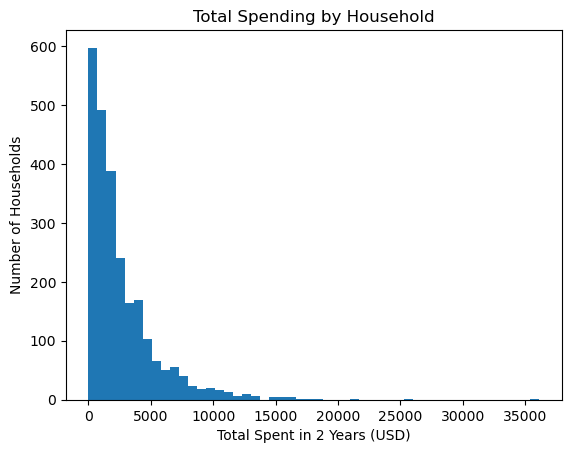

In [65]:
# look at histogram of the distribution of spending by household
plt.hist(amt_pd_by_household['amt_paid'],50)
plt.title('Total Spending by Household')
plt.xlabel('Total Spent in 2 Years (USD)')
plt.ylabel('Number of Households')
plt.show;

<b> I am now going to divide my transaction data up into transactions that used a discount, and those that didn't. I will also create different dataframes for the different types of discounts used. </b>

In [66]:
# Dataframe for transactions that used any sort of discount

disc_mask = (transaction_data['coupon_disc'] < 0) | (transaction_data['coupon_match_disc'] < 0) | (transaction_data['retail_disc'] < 0)

discount_transactions = transaction_data[disc_mask]

discount_transactions.head()

household_key    basket_id  store_id  day  week_no trans_time  product_id  \
0           2375  26984851472       364    1        1      16:31     1004906   
2           2375  26984851472       364    1        1      16:31     1036325   
4           2375  26984851472       364    1        1      16:31     8160430   
5           2375  26984851516       364    1        1      16:42      826249   
6           2375  26984851516       364    1        1      16:42     1043142   

   sales_value  amt_paid  retail_disc  coupon_disc  coupon_match_disc  
0         1.39      0.79        -0.60          0.0                0.0  
2         0.99      0.69        -0.30          0.0                0.0  
4         1.50      1.11        -0.39          0.0                0.0  
5         1.98      1.38        -0.60          0.0                0.0  
6         1.57      0.89        -0.68          0.0                0.0

In [67]:
# Dataframe for transactions that paid full price

no_disc_mask = ~disc_mask

no_discount_transactions = transaction_data[no_disc_mask]

no_discount_transactions.head()

household_key    basket_id  store_id  day  week_no trans_time  product_id  \
1            2375  26984851472       364    1        1      16:31     1033142   
3            2375  26984851472       364    1        1      16:31     1082185   
8            2375  26984851516       364    1        1      16:42     1102651   
11           1364  26984896261     31742    1        1      15:20      842930   
13           1364  26984896261     31742    1        1      15:20      920955   

    sales_value  amt_paid  retail_disc  coupon_disc  coupon_match_disc  
1          0.82      0.82          0.0          0.0                0.0  
3          1.21      1.21          0.0          0.0                0.0  
8          1.89      1.89          0.0          0.0                0.0  
11         2.19      2.19          0.0          0.0                0.0  
13         3.09      3.09          0.0          0.0                0.0

In [68]:
# Dataframe for transactions that used a coupon

disc_mask_coupon = (discount_transactions['coupon_disc'] < 0)

coupon_trans = discount_transactions[disc_mask_coupon]

coupon_trans.head()

household_key    basket_id  store_id  day  week_no trans_time  \
129            718  26985360571       324    1        1      11:15   
134            718  26985360571       324    1        1      11:15   
151            718  26985360571       324    1        1      11:15   
154            718  26985360571       324    1        1      11:15   
160            718  26985360571       324    1        1      11:15   

     product_id  sales_value  amt_paid  retail_disc  coupon_disc  \
129      830503         2.99      0.99        -1.00        -1.00   
134      855325         1.10     -0.39        -0.69        -0.40   
151      934676         1.37     -0.05        -0.42        -1.00   
154      948756         2.12      0.22        -0.90        -0.75   
160      965292         3.50      1.22        -1.28        -1.00   

     coupon_match_disc  
129               0.00  
134              -0.40  
151               0.00  
154              -0.25  
160               0.00

In [69]:
# Dataframe for transactions that used a coupon match -NOTE THAT SOME OF THE PRICES PAID ARE NEGATIVE! 

coupon_match_mask = (discount_transactions['coupon_match_disc'] < 0)

coupon_match_trans = discount_transactions[coupon_match_mask]

coupon_match_trans.head().sort_values(by='amt_paid')

household_key    basket_id  store_id  day  week_no trans_time  \
594            122  27008905909       330    3        1      11:56   
236           2305  26996870743       414    2        1      13:00   
134            718  26985360571       324    1        1      11:15   
154            718  26985360571       324    1        1      11:15   
210            718  26985360571       324    1        1      11:15   

     product_id  sales_value  amt_paid  retail_disc  coupon_disc  \
594     6514251         4.25     -0.62        -1.87        -2.25   
236     1043128         1.53     -0.47        -1.00        -0.55   
134      855325         1.10     -0.39        -0.69        -0.40   
154      948756         2.12      0.22        -0.90        -0.75   
210     9368449         2.05      0.56        -0.49        -0.55   

     coupon_match_disc  
594              -0.75  
236              -0.45  
134              -0.40  
154              -0.25  
210              -0.45

In [70]:
# Dataframe for transactions that used a loyalty card.
loyalty_mask = (discount_transactions['retail_disc'] < 0)
loyalty_card_trans = discount_transactions[loyalty_mask]
loyalty_card_trans.head()

household_key    basket_id  store_id  day  week_no trans_time  product_id  \
0           2375  26984851472       364    1        1      16:31     1004906   
2           2375  26984851472       364    1        1      16:31     1036325   
4           2375  26984851472       364    1        1      16:31     8160430   
5           2375  26984851516       364    1        1      16:42      826249   
6           2375  26984851516       364    1        1      16:42     1043142   

   sales_value  amt_paid  retail_disc  coupon_disc  coupon_match_disc  
0         1.39      0.79        -0.60          0.0                0.0  
2         0.99      0.69        -0.30          0.0                0.0  
4         1.50      1.11        -0.39          0.0                0.0  
5         1.98      1.38        -0.60          0.0                0.0  
6         1.57      0.89        -0.68          0.0                0.0

In [71]:
# Summary of transactions by discount type
print('Number of transactions that had a discount of some kind: ',discount_transactions.shape[0])
print('Number of transactions with no discounts: ', no_discount_transactions.shape[0])
print('Number of transactions that used a coupon: ', coupon_trans.shape[0])
print('Number of transactions that used a coupon match: ', coupon_match_trans.shape[0])
print('Number of transactions that used a loyalty card: ', loyalty_card_trans.shape[0])

Number of transactions that had a discount of some kind:  1314435
Number of transactions with no discounts:  1266831
Number of transactions that used a coupon:  31467
Number of transactions that used a coupon match:  17449
Number of transactions that used a loyalty card:  1303017


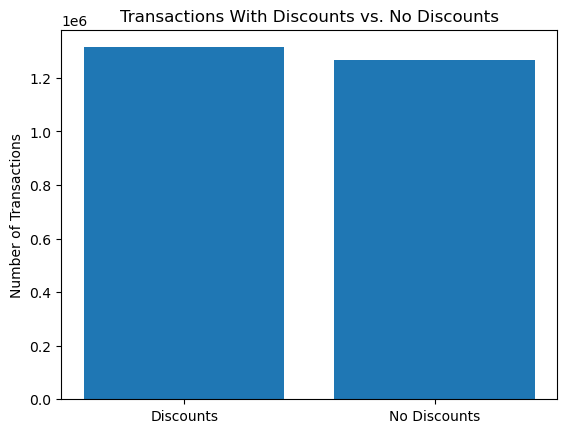

In [72]:
plt.bar(['Discounts', 'No Discounts'], [len(discount_transactions), len(no_discount_transactions)])
plt.ylabel('Number of Transactions')
plt.title ('Transactions With Discounts vs. No Discounts')
plt.show();

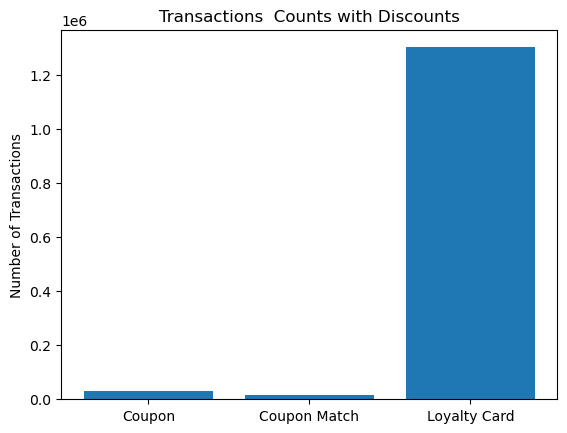

In [73]:
plt.bar(['Coupon', 'Coupon Match', 'Loyalty Card'], [len(coupon_trans), len(coupon_match_trans), len(loyalty_card_trans)])
plt.ylabel('Number of Transactions')
plt.title ('Transactions  Counts with Discounts')
plt.show();

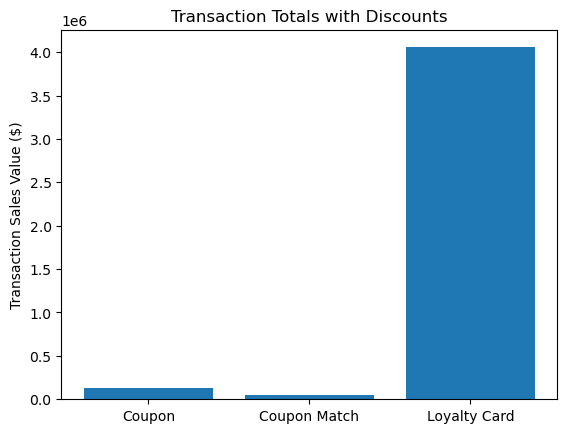

In [74]:
plt.bar(['Coupon', 'Coupon Match', 'Loyalty Card'], [coupon_trans['sales_value'].sum(), coupon_match_trans['sales_value'].sum(), loyalty_card_trans['sales_value'].sum()])
plt.ylabel('Transaction Sales Value ($)')
plt.title ('Transaction Totals with Discounts')
plt.show();

In [75]:
# what percentage of households use a loyalty card?

loyalty_card_users = transaction_data.groupby('household_key')['retail_disc'].apply(lambda x: (x< 0).any())

loyalty_percentage = (loyalty_card_users.sum()/len(loyalty_card_users))*100
print('Percentage of Households Using Loyalty Card: ', loyalty_percentage,'%')
                    

Percentage of Households Using Loyalty Card:  100.0 %


This indicates that all customers use a loyalty card at least some of the time. 

In [76]:
loyalty_card_basket = transaction_data.groupby('basket_id')['retail_disc'].apply(lambda x: (x< 0).any())

loyalty_percentage = (loyalty_card_basket.sum()/len(loyalty_card_basket))*100
print('Percentage of Baskets Using Loyalty Card: ', loyalty_percentage,'%')

Percentage of Baskets Using Loyalty Card:  83.56839163576656 %


It seems all customers use loyalty cards, and 83.4% of the baskets used a loyalty card for at least one purchase. Because customers tend to use their loyalty cards, I think we can actually disregard loyalty cards in the remaining EDA.

## 1.6.3 Extended EDA: Demographics and Coupon Use Data <a id='1.6.3'></a>
In this section I will be merging tables and digging deeper into the data

In [77]:
coupon_trans.columns

Index(['household_key', 'basket_id', 'store_id', 'day', 'week_no',
       'trans_time', 'product_id', 'sales_value', 'amt_paid', 'retail_disc',
       'coupon_disc', 'coupon_match_disc'],
      dtype='object')

In [78]:
# Make a table combining household demographics and the amounts paid, sales values and discounts for each household

query = """ 
SELECT h.*, c.basket_id, c.store_id, c.store_id, c.day, c.week_no, c.trans_time, c.product_id, c.sales_value, c.amt_paid, c.retail_disc, c.coupon_disc, c.coupon_match_disc
FROM coupon_trans AS c
INNER JOIN hh_demographic AS h
ON c.household_key = h.household_key; """

demo_coupon = psql.sqldf(query,locals())

In [79]:
# Summary stats
demo_coupon.describe().round(0).astype(int)

household_key   basket_id  store_id  store_id    day  week_no  \
count          21478       21478     21478     21478  21478    21478   
mean            1278 -2147483648      3208      3208    412       60   
std              784 -2147483648      9039      9039    181       26   
min                1 -2147483648       105       105      1        1   
25%              518 -2147483648       341       341    256       37   
50%             1364 -2147483648       382       382    422       61   
75%             1990 -2147483648       424       424    572       82   
max             2499 -2147483648     34280     34280    711      102   

       product_id  sales_value  amt_paid  retail_disc  coupon_disc  \
count       21478        21478     21478        21478        21478   
mean      4257180            4         2           -1           -1   
std       4782074            5         4            2            1   
min         32608            0       -27          -87          -56   
25%        937301            2         0           -1           -1   
50%       1067185            3         1            0           -1   
75%       8090509            4         2            0            0   
max      18316298          176       171            0            0   

       coupon_match_disc  
count              21478  
mean                   0  
std                    0  
min                   -4  
25%                    0  
50%                    0  
75%                    0  
max                    0

In [80]:
demo_coupon.head()

age_desc marital_status income_desc homeowner_desc   hh_comp_desc  \
0    45-54        Married      25-34K      Homeowner  2 Adults Kids   
1    45-54        Married      25-34K      Homeowner  2 Adults Kids   
2    45-54        Married      25-34K      Homeowner  2 Adults Kids   
3    45-54        Married      25-34K      Homeowner  2 Adults Kids   
4    45-54        Married      25-34K      Homeowner  2 Adults Kids   

  household_size_desc kid_category_desc  household_key    basket_id  store_id  \
0                  5+                3+            718  26985360571       324   
1                  5+                3+            718  26985360571       324   
2                  5+                3+            718  26985360571       324   
3                  5+                3+            718  26985360571       324   
4                  5+                3+            718  26985360571       324   

   store_id  day  week_no trans_time  product_id  sales_value  amt_paid  \
0       324    1        1      11:15      830503         2.99      0.99   
1       324    1        1      11:15      855325         1.10     -0.39   
2       324    1        1      11:15      934676         1.37     -0.05   
3       324    1        1      11:15      948756         2.12      0.22   
4       324    1        1      11:15      965292         3.50      1.22   

   retail_disc  coupon_disc  coupon_match_disc  
0        -1.00        -1.00               0.00  
1        -0.69        -0.40              -0.40  
2        -0.42        -1.00               0.00  
3        -0.90        -0.75              -0.25  
4        -1.28        -1.00               0.00

In [81]:
# I'd like to do a further join to get the coupon and campaign info in there too. 
query = """
SELECT d.*, c.coupon_upc, c.campaign
FROM demo_coupon AS d
INNER JOIN coupon_redempt AS c
ON d.household_key = c.household_key
"""

demo_coupon = psql.sqldf(query,locals())

In [82]:
demo_coupon.head()

age_desc marital_status income_desc homeowner_desc   hh_comp_desc  \
0    45-54        Married      25-34K      Homeowner  2 Adults Kids   
1    45-54        Married      25-34K      Homeowner  2 Adults Kids   
2    45-54        Married      25-34K      Homeowner  2 Adults Kids   
3    45-54        Married      25-34K      Homeowner  2 Adults Kids   
4    45-54        Married      25-34K      Homeowner  2 Adults Kids   

  household_size_desc kid_category_desc  household_key    basket_id  store_id  \
0                  5+                3+            718  26985360571       324   
1                  5+                3+            718  26985360571       324   
2                  5+                3+            718  26985360571       324   
3                  5+                3+            718  26985360571       324   
4                  5+                3+            718  26985360571       324   

   day  week_no trans_time  product_id  sales_value  amt_paid  retail_disc  \
0    1        1      11:15      830503         2.99      0.99         -1.0   
1    1        1      11:15      830503         2.99      0.99         -1.0   
2    1        1      11:15      830503         2.99      0.99         -1.0   
3    1        1      11:15      830503         2.99      0.99         -1.0   
4    1        1      11:15      830503         2.99      0.99         -1.0   

   coupon_disc  coupon_match_disc   coupon_upc  campaign  
0         -1.0                0.0  51111070124        30  
1         -1.0                0.0  51111074242        26  
2         -1.0                0.0  53600000082        10  
3         -1.0                0.0  53620010028        27  
4         -1.0                0.0  55703711082        18

<b>The above table demo_coupon contains all of the demographics, along with the transactions from each household, and the campaign number of the coupons they redeemed.</b>

In [83]:
# Create df of demographics of purchases that did NOT use discounts

query = """ 
SELECT h.*, n.basket_id, n.store_id, n.store_id, n.day, n.week_no, n.trans_time, n.product_id, n.sales_value, n.amt_paid, n.retail_disc, n.coupon_disc, n.coupon_match_disc
FROM no_discount_transactions AS n
INNER JOIN hh_demographic AS h
ON n.household_key = h.household_key; """

demo_no_disc = psql.sqldf(query,locals())


In [84]:
demo_no_disc.describe().round(0).astype(int)

household_key   basket_id  store_id  store_id     day  week_no  \
count         698172      698172    698172    698172  698172   698172   
mean            1271 -2147483648      3345      3345     393       57   
std              736 -2147483648      9227      9227     186       27   
min                1 -2147483648         1         1       1        1   
25%              644 -2147483648       334       334     238       35   
50%             1261 -2147483648       375       375     397       57   
75%             1929 -2147483648       424       424     551       79   
max             2499 -2147483648     34280     34280     711      102   

       product_id  sales_value  amt_paid  retail_disc  coupon_disc  \
count      698172       698172    698172       698172       698172   
mean      2858360            3         3            0            0   
std       3862963            4         4            0            0   
min         25671            0         0            0            0   
25%        919681            1         1            0            0   
50%       1029743            2         2            0            0   
75%       1127624            4         4            0            0   
max      18294080          840       840            0            0   

       coupon_match_disc  
count             698172  
mean                   0  
std                    0  
min                    0  
25%                    0  
50%                    0  
75%                    0  
max                    0

In [85]:
demo_no_disc.head()

age_desc marital_status income_desc homeowner_desc   hh_comp_desc  \
0      65+         Single    100-124K      Homeowner  Single Female   
1      65+         Single    100-124K      Homeowner  Single Female   
2    35-44        Unknown      35-49K        Unknown   1 Adult Kids   
3    35-44        Unknown      35-49K        Unknown   1 Adult Kids   
4    35-44        Unknown      35-49K        Unknown   1 Adult Kids   

  household_size_desc kid_category_desc  household_key    basket_id  store_id  \
0                   1      None/Unknown           1364  26984896261     31742   
1                   1      None/Unknown           1364  26984896261     31742   
2                   2                 1             98  26984951769       337   
3                   2                 1             98  26984951769       337   
4                   2                 1             98  26984951769       337   

   store_id  day  week_no trans_time  product_id  sales_value  amt_paid  \
0     31742    1        1      15:20      842930         2.19      2.19   
1     31742    1        1      15:20      920955         3.09      3.09   
2       337    1        1      19:37      878302         0.90      0.90   
3       337    1        1      19:37     1082185         0.39      0.39   
4       337    1        1      19:37     1087347         0.25      0.25   

   retail_disc  coupon_disc  coupon_match_disc  
0          0.0          0.0                0.0  
1          0.0          0.0                0.0  
2          0.0          0.0                0.0  
3          0.0          0.0                0.0  
4          0.0          0.0                0.0

<b> Look at age for demo_coupon </b>

In [86]:
# AGE GROUPS:
demo_coupon['age_desc'].unique()

array(['45-54', '55-64', '35-44', '25-34', '65+', '19-24'], dtype=object)

In [87]:
# Filtering for the different age groups, in the table of combined demographic and coupon/sales values
age_19_24 = demo_coupon[demo_coupon['age_desc'] == '19-24']
age_25_34 = demo_coupon[demo_coupon['age_desc'] == '25-34']
age_35_44 = demo_coupon[demo_coupon['age_desc'] == '35-44']
age_45_54 = demo_coupon[demo_coupon['age_desc'] == '45-54']
age_55_64 = demo_coupon[demo_coupon['age_desc'] == '55-64']
age_65_plus = demo_coupon[demo_coupon['age_desc'] == '65+']

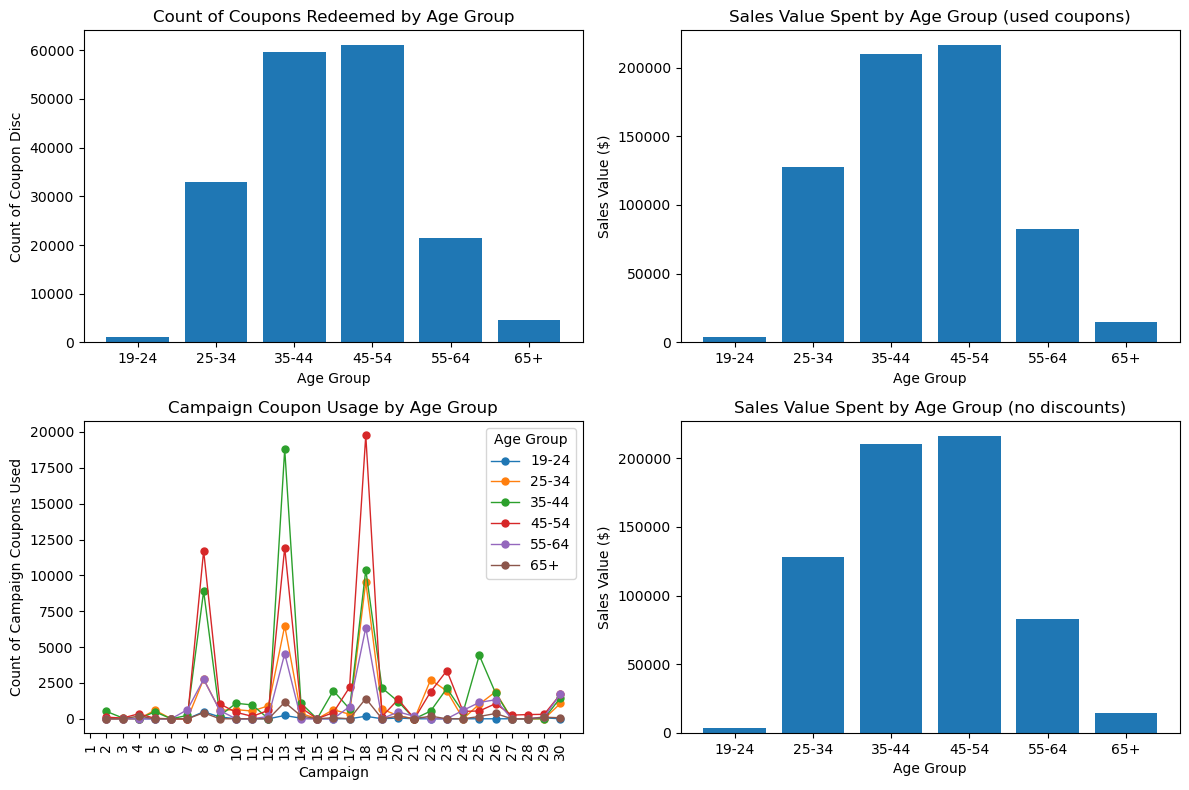

In [88]:
# Compare plots of ages with different variables

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Count of Coupons Redeeed by Age Group
age_groups_count = demo_coupon.groupby('age_desc')['coupon_disc'].count()
axes[0, 0].bar(age_groups_count.index, age_groups_count)
axes[0, 0].set_xlabel('Age Group')
axes[0, 0].set_ylabel('Count of Coupon Disc')
axes[0, 0].set_title('Count of Coupons Redeemed by Age Group')

# Plot 2: Sales Value Spent by Age Group
age_groups_sales = demo_coupon.groupby('age_desc')['sales_value'].sum()
axes[0, 1].bar(age_groups_sales.index, age_groups_sales)
axes[0, 1].set_xlabel('Age Group')
axes[0, 1].set_ylabel('Sales Value ($)')
axes[0, 1].set_title('Sales Value Spent by Age Group (used coupons)')

# Plot 3:  How effective campaigns were (in terms of coupon redemption counts) across age groups

campaign_counts = demo_coupon.groupby(['campaign', 'age_desc'])['campaign'].count().unstack(fill_value=0)

campaign_counts.plot(kind='line', marker='o', markersize=5, linewidth=1, ax=axes[1, 0])
axes[1, 0].set_xlabel('Campaign')
axes[1, 0].set_ylabel('Count of Campaign Coupons Used')
axes[1, 0].set_title('Campaign Coupon Usage by Age Group')
axes[1, 0].set_xticks(np.arange(1, 31))
axes[1, 0].tick_params(axis='x', rotation=90)
axes[1, 0].legend(title='Age Group', loc='upper right')

# Plot 4: Sales Value Spent by Age Group Who Did NOt Redeem Coupons

no_discount_transactions

age_groups_sales_nodisc = demo_no_disc.groupby('age_desc')['sales_value'].sum()
axes[1, 1].bar(age_groups_sales_nodisc.index, age_groups_sales)
axes[1, 1].set_xlabel('Age Group')
axes[1, 1].set_ylabel('Sales Value ($)')
axes[1, 1].set_title('Sales Value Spent by Age Group (no discounts)')

plt.tight_layout()
plt.show()

Above we can see that the distributions for sales values/coupon redemption counts stay consistent among age groups, but that certain campaigns had a lot more activity than others. Here arey are in ranking of the number of coupons redemed within a campaign, there the top 3 campaigns made of the majority of redemptions:
* 18
* 13
* 8
* 25
* 23
* 22
* 30
* 26

<b> NOTE: in the Campaign Coupon Usage by Age Group plot above, we can see that the plots 8,13 and 18 were redeemed the most. However, remember that above we found out that those were the campaigns that were sent out the most, by similar margins. This indicates that across age groups, the redemption rate may be proportional to how many campaigns the households are sent. 
    
<b> I'd like to look into these campaigns a bit more.</b>

In [89]:
# Get a count of campaigns that different groups responded to
campaign_counts

age_desc  19-24  25-34  35-44  45-54  55-64   65+
campaign                                         
2             0      0    516    113      0     0
3             0      0     62     51      0     0
4             0      0      9    350      0   185
5             0    598    488     30      0     0
6             0      0      0      0      0     9
7             0      0    238      0    635     0
8           492   2764   8902  11717   2751   420
9           128    589    216   1034    570     0
10            0    642   1081    451      0     0
11            0    536    966    170      0     0
12            0    912      0    590    164     0
13          232   6481  18793  11928   4542  1152
14           39    378   1091    771      0   201
15            0      0      0      1      0     0
16            0    633   1959    435      0    76
17            0    316    688   2196    855     0
18          178   9556  10384  19776   6352  1414
19            0    681   2152    159      0     0
20           52    205   1198   1351    485   185
21            0      0      0      3    170     0
22            0   2721    538   1886      0   185
23            0   1933   2120   3362      6     0
24            0      3    459    516    590     0
25            0   1018   4428    544   1140   159
26            0   1879   1801   1053   1327   370
27            0      0      0    257      0     0
28            0      0      0    295      0     0
29           66      0     11    312    130   108
30            0   1068   1464   1701   1728    75

In [90]:
# What are the total counts for responses to each campaign?

query = """
SELECT campaign, COUNT(*) as count
FROM demo_coupon
GROUP BY campaign
ORDER BY count DESC;
"""

result = psql.sqldf(query, locals())
print(result)


    campaign  count
0         18  47660
1         13  43128
2          8  27046
3         23   7421
4         25   7289
5         26   6430
6         30   6036
7         22   5330
8         17   4055
9         20   3476
10        16   3103
11        19   2992
12         9   2537
13        14   2480
14        10   2174
15        11   1672
16        12   1666
17        24   1568
18         5   1116
19         7    873
20         2    629
21        29    627
22         4    544
23        28    295
24        27    257
25        21    173
26         3    113
27         6      9
28        15      1


<b>Above we saw campaigns 18,13, and 8 had the highest responses, which also correspond to the campaigns that were sent out the most. I'd like to look at these more carefully.</b>

In [91]:
# write a query to only show data from demo_coupon that responded to the top 3 campaigns
query="""
SELECT *
FROM demo_coupon
WHERE campaign = 18 OR campaign = 13 OR campaign = 8;
"""

top_campaigns_demo = psql.sqldf(query,locals())
top_campaigns_demo

age_desc marital_status income_desc homeowner_desc      hh_comp_desc  \
0         45-54        Married      25-34K      Homeowner     2 Adults Kids   
1         45-54        Married      25-34K      Homeowner     2 Adults Kids   
2         45-54        Married      25-34K      Homeowner     2 Adults Kids   
3         45-54        Married      25-34K      Homeowner     2 Adults Kids   
4         45-54        Married      25-34K      Homeowner     2 Adults Kids   
...         ...            ...         ...            ...               ...   
117829    45-54        Married      75-99K      Homeowner  2 Adults No Kids   
117830    45-54        Married      75-99K      Homeowner  2 Adults No Kids   
117831    45-54        Married      75-99K      Homeowner  2 Adults No Kids   
117832    45-54        Married      75-99K      Homeowner  2 Adults No Kids   
117833    45-54        Married      75-99K      Homeowner  2 Adults No Kids   

       household_size_desc kid_category_desc  household_key    basket_id  \
0                       5+                3+            718  26985360571   
1                       5+                3+            718  26985360571   
2                       5+                3+            718  26985360571   
3                       5+                3+            718  26985360571   
4                       5+                3+            718  26985360571   
...                    ...               ...            ...          ...   
117829                   2      None/Unknown           1823  42289906117   
117830                   2      None/Unknown           1823  42289906117   
117831                   2      None/Unknown           1823  42289906117   
117832                   2      None/Unknown           1823  42289906117   
117833                   2      None/Unknown           1823  42289906117   

        store_id  day  week_no trans_time  product_id  sales_value  amt_paid  \
0            324    1        1      11:15      830503         2.99      0.99   
1            324    1        1      11:15      855325         1.10     -0.39   
2            324    1        1      11:15      934676         1.37     -0.05   
3            324    1        1      11:15      948756         2.12      0.22   
4            324    1        1      11:15      965292         3.50      1.22   
...          ...  ...      ...        ...         ...          ...       ...   
117829       402  711      102      13:34    17249766         2.56      1.56   
117830       402  711      102      13:34    17249766         2.56      1.56   
117831       402  711      102      13:34    17249766         2.56      1.56   
117832       402  711      102      13:34    17249766         2.56      1.56   
117833       402  711      102      13:34    17249766         2.56      1.56   

        retail_disc  coupon_disc  coupon_match_disc   coupon_upc  campaign  
0             -1.00        -1.00               0.00  55703711082        18  
1             -0.69        -0.40              -0.40  55703711082        18  
2             -0.42        -1.00               0.00  55703711082        18  
3             -0.90        -0.75              -0.25  55703711082        18  
4             -1.28        -1.00               0.00  55703711082        18  
...             ...          ...                ...          ...       ...  
117829         0.00        -1.00               0.00  54300026050        18  
117830         0.00        -1.00               0.00  54650050060        13  
117831         0.00        -1.00               0.00  55000013950        18  
117832         0.00        -1.00               0.00  55100012140         8  
117833         0.00        -1.00               0.00  57680810050        13  

[117834 rows x 21 columns]

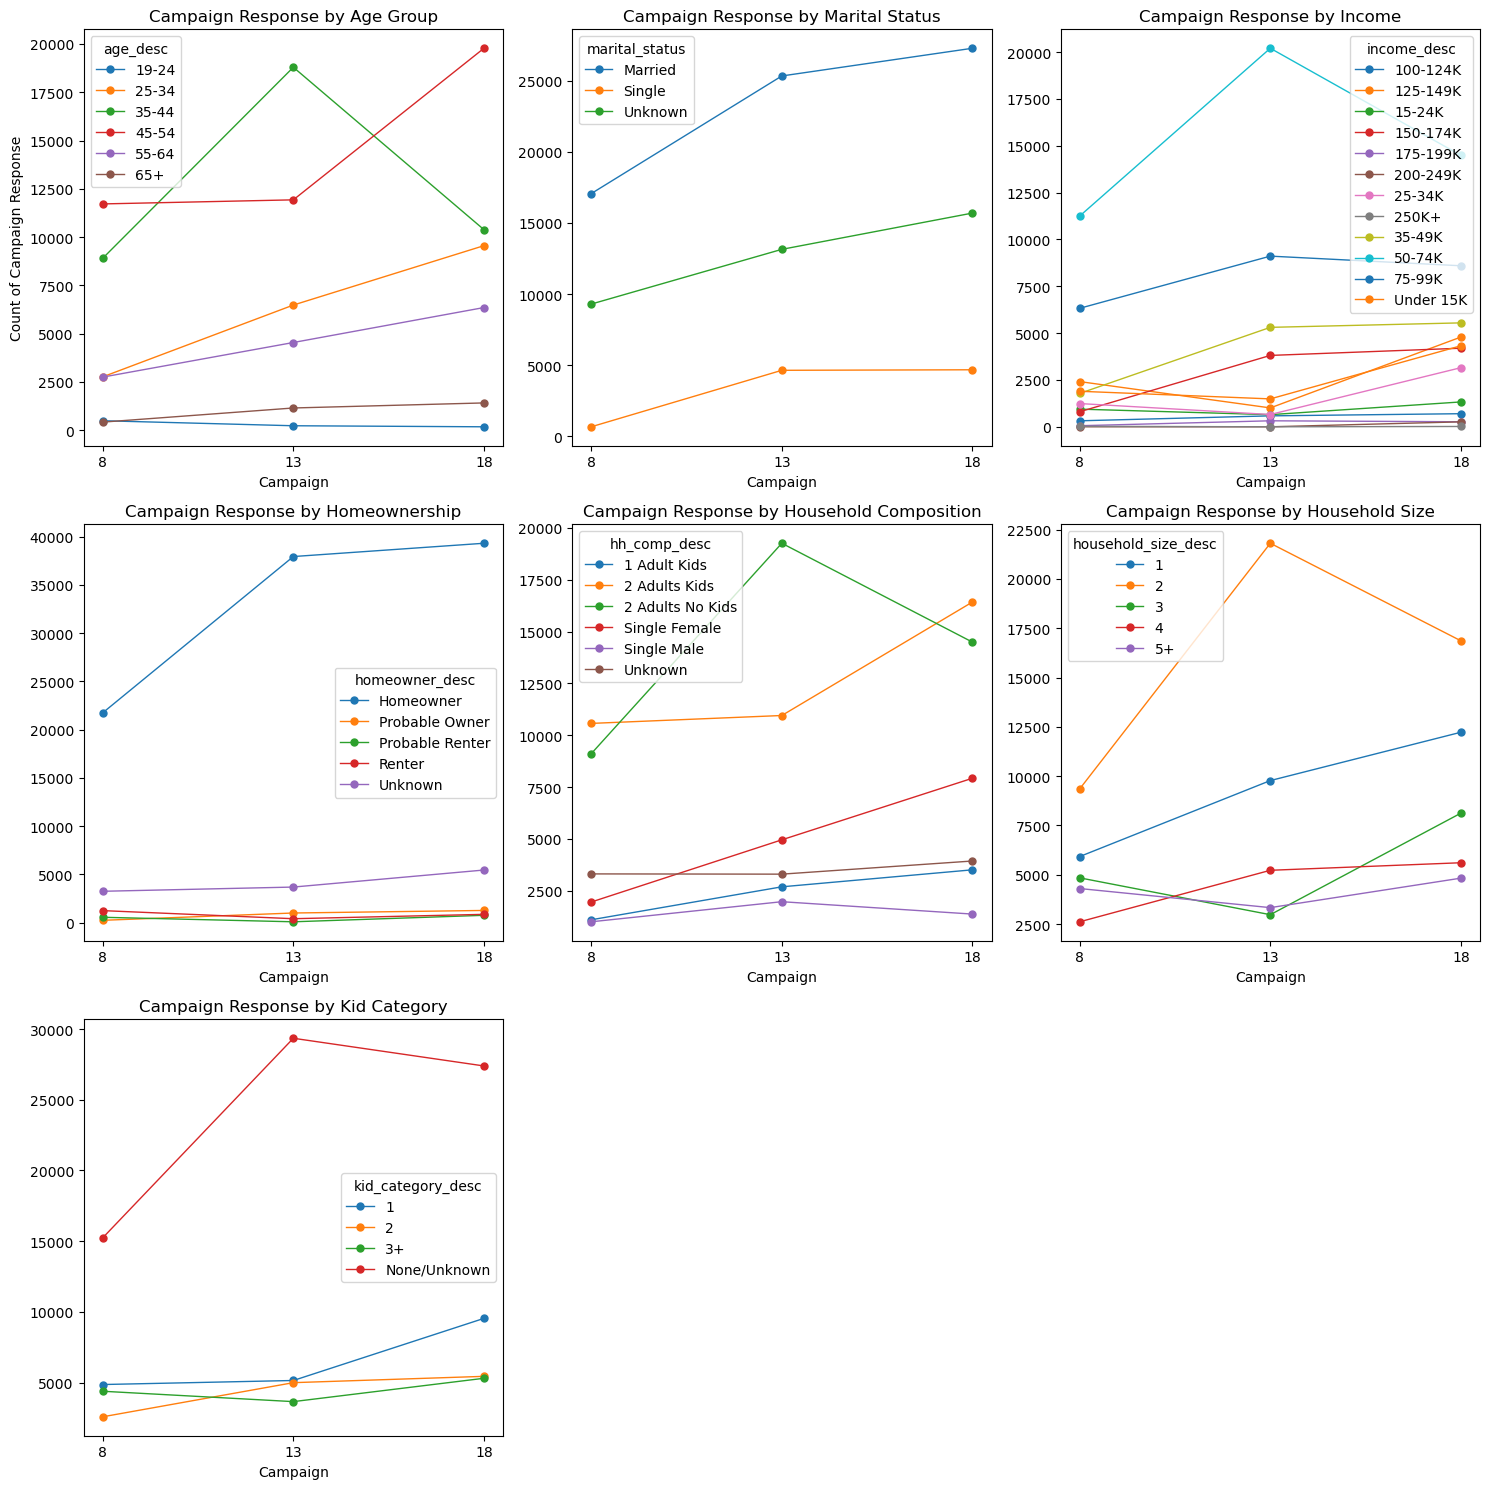

In [92]:
# Plotting the coupon redemption (grouped under top 3 performing campaigns)

age_counts = top_campaigns_demo.groupby(['campaign', 'age_desc'])['campaign'].count().unstack(fill_value=0)
marital_counts =  top_campaigns_demo.groupby(['campaign', 'marital_status'])['campaign'].count().unstack(fill_value=0)
income_counts =  top_campaigns_demo.groupby(['campaign', 'income_desc'])['campaign'].count().unstack(fill_value=0)
homeowner_counts = top_campaigns_demo.groupby(['campaign', 'homeowner_desc'])['campaign'].count().unstack(fill_value=0)
hh_counts =  top_campaigns_demo.groupby(['campaign', 'hh_comp_desc'])['campaign'].count().unstack(fill_value=0)
size_count = top_campaigns_demo.groupby(['campaign', 'household_size_desc'])['campaign'].count().unstack(fill_value=0)
kid_count = top_campaigns_demo.groupby(['campaign', 'kid_category_desc'])['campaign'].count().unstack(fill_value=0)


fig, axes = plt.subplots(3, 3, figsize=(15, 15)) 

# First subplot: Age Groups
age_counts.plot(kind='line', marker='o', markersize=5, linewidth=1, ax=axes[0, 0])
axes[0, 0].set_xticks([8, 13, 18])
axes[0, 0].set_xlabel('Campaign')
axes[0, 0].set_ylabel('Count of Campaign Response')
axes[0, 0].set_title('Campaign Response by Age Group')

# Second subplot: Marital Status
marital_counts.plot(kind='line', marker='o', markersize=5, linewidth=1, ax=axes[0, 1])
axes[0, 1].set_xticks([8, 13, 18])
axes[0, 1].set_xlabel('Campaign')
axes[0, 1].set_title('Campaign Response by Marital Status')

# Third subplot: Income
income_counts.plot(kind='line', marker='o', markersize=5, linewidth=1, ax=axes[0, 2])
axes[0, 2].set_xticks([8, 13, 18])
axes[0, 2].set_xlabel('Campaign')
axes[0, 2].set_title('Campaign Response by Income')

# Fourth subplot: Homeownership
homeowner_counts.plot(kind='line', marker='o', markersize=5, linewidth=1, ax=axes[1, 0])
axes[1, 0].set_xticks([8, 13, 18])
axes[1, 0].set_xlabel('Campaign')
axes[1, 0].set_title('Campaign Response by Homeownership')

# Fifth subplot: Household Composition
hh_counts.plot(kind='line', marker='o', markersize=5, linewidth=1, ax=axes[1, 1])
axes[1, 1].set_xticks([8, 13, 18])
axes[1, 1].set_xlabel('Campaign')
axes[1, 1].set_title('Campaign Response by Household Composition')

# Sixth subplot: Household Size
size_count.plot(kind='line', marker='o', markersize=5, linewidth=1, ax=axes[1, 2])
axes[1, 2].set_xticks([8, 13, 18])
axes[1, 2].set_xlabel('Campaign')
axes[1, 2].set_title('Campaign Response by Household Size')

# Seventh subplot: Kid Category
kid_count.plot(kind='line', marker='o', markersize=5, linewidth=1, ax=axes[2, 0])
axes[2, 0].set_xticks([8, 13, 18])
axes[2, 0].set_xlabel('Campaign')
axes[2, 0].set_title('Campaign Response by Kid Category')

# Hide unused subplots
axes[2, 1].axis('off')
axes[2, 2].axis('off')

plt.tight_layout()
plt.show();


The general trend that I see for campaign response is that overall there was the most response to 18, followed by 13 and 8. However, for any given demographic category there was usually one demographic group that responded most to 13. 
Generally, the groups that responded the most to campaigns were:
* Ages 35-54
* Married
* Earned 50-99K
* Homeowners
* 2 adult households (both with kids and no kids)
* 1-2 household size
* No/unknown number of kids

This mostly aligns with the distribution of how campaigns were sent out. However, I do see some notable differences:
*	Married and ‘Unknown’ were went similar numbers of campaigns, but the married households responded much more. 
*	Income group 35-49 were sent more campaigns than 75-99 K, but the higher income group responded much more. 
*	Homeowners were went about twice as many coupons as ‘Unknown’ owners, but redeemed 5-8x as many coupons. 
From this I can conclude that it’s likely that focusing on the above demographics would yield higher campaign response rates. 


In [93]:
# So that I don't run into memory issues, filter transaction_data for the rows where the household_key is in hh_demographic
filtered_transaction_data = transaction_data[transaction_data['household_key'].isin(hh_demographic['household_key'])]

# Join with hh_demographic and product
query = """
SELECT hh.*, t.product_id, t.sales_value, t.coupon_disc, p.commodity_desc
FROM hh_demographic AS hh
LEFT JOIN filtered_transaction_data AS t 
ON hh.household_key = t.household_key
LEFT JOIN product AS p 
ON t.product_id = p.product_id;
"""

demo_product = psql.sqldf(query, locals())


In [94]:
demo_product.head()

age_desc marital_status income_desc homeowner_desc      hh_comp_desc  \
0      65+        Married      35-49K      Homeowner  2 Adults No Kids   
1      65+        Married      35-49K      Homeowner  2 Adults No Kids   
2      65+        Married      35-49K      Homeowner  2 Adults No Kids   
3      65+        Married      35-49K      Homeowner  2 Adults No Kids   
4      65+        Married      35-49K      Homeowner  2 Adults No Kids   

  household_size_desc kid_category_desc  household_key  product_id  \
0                   2      None/Unknown              1      819312   
1                   2      None/Unknown              1      820165   
2                   2      None/Unknown              1      820165   
3                   2      None/Unknown              1      820165   
4                   2      None/Unknown              1      821815   

   sales_value  coupon_disc           commodity_desc  
0         5.67          0.0  IN-STORE PHOTOFINISHING  
1         1.50          0.0                   CITRUS  
2         2.00          0.0                   CITRUS  
3         2.00          0.0                   CITRUS  
4         3.38          0.0         DRY SAUCES/GRAVY

In [95]:
demo_product.columns

Index(['age_desc', 'marital_status', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'household_key', 'product_id', 'sales_value', 'coupon_disc',
       'commodity_desc'],
      dtype='object')

<b> Below I will aggregate my data in demo_product so that I can see what commodity types the different demographic groups purchased, the sales values, and what percentage of these sales use coupons.</b>

In [97]:
# First aggregate data to separate out the rows that used coupons and those that did not. 

# With coupons
grouped_with_coupons = demo_product[demo_product['coupon_disc'] != 0].groupby(
    ['age_desc', 'marital_status', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'commodity_desc']
).agg(
    {'sales_value': 'sum'}
).reset_index()
grouped_with_coupons = grouped_with_coupons.rename(columns={'sales_value': 'sales_value_with_coupon'})

# Without coupons
grouped_without_coupons = demo_product[demo_product['coupon_disc'] == 0].groupby(
    ['age_desc', 'marital_status', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc', 'commodity_desc']
).agg(
    {'sales_value': 'sum'}
).reset_index()
grouped_without_coupons = grouped_without_coupons.rename(columns={'sales_value': 'sales_value_without_coupon'})


In [98]:
# Create new DF merged_data where I have the demographics as well as the sales values with and without coupons for that group

merged_data = pd.merge(grouped_with_coupons, grouped_without_coupons, on=['age_desc', 'marital_status', 'income_desc', 'homeowner_desc','hh_comp_desc', 'household_size_desc', 'kid_category_desc','commodity_desc'], suffixes=('_with_coupon', '_without_coupon'))

# Calculate the percentage of sales with coupons for each group
merged_data['percent_sales_with_coupon'] = (merged_data['sales_value_with_coupon'] / (merged_data['sales_value_with_coupon'] + merged_data['sales_value_without_coupon'])) * 100

merged_data

age_desc marital_status income_desc homeowner_desc      hh_comp_desc  \
0       19-24        Married      15-24K      Homeowner  2 Adults No Kids   
1       19-24        Married      15-24K      Homeowner  2 Adults No Kids   
2       19-24        Married      15-24K      Homeowner  2 Adults No Kids   
3       19-24        Married      15-24K      Homeowner  2 Adults No Kids   
4       19-24        Married      35-49K      Homeowner  2 Adults No Kids   
...       ...            ...         ...            ...               ...   
8231      65+        Unknown   Under 15K      Homeowner     Single Female   
8232      65+        Unknown   Under 15K      Homeowner     Single Female   
8233      65+        Unknown   Under 15K      Homeowner     Single Female   
8234      65+        Unknown   Under 15K         Renter       Single Male   
8235      65+        Unknown   Under 15K         Renter       Single Male   

     household_size_desc kid_category_desc              commodity_desc  \
0                      2      None/Unknown                      BLEACH   
1                      2      None/Unknown  CHARCOAL AND LIGHTER FLUID   
2                      2      None/Unknown           CONDIMENTS/SAUCES   
3                      2      None/Unknown          LAUNDRY DETERGENTS   
4                      2      None/Unknown                  BAG SNACKS   
...                  ...               ...                         ...   
8231                   1      None/Unknown                        SOUP   
8232                   1      None/Unknown   VEGETABLES - SHELF STABLE   
8233                   1      None/Unknown            WAREHOUSE SNACKS   
8234                   1      None/Unknown                      CHEESE   
8235                   1      None/Unknown       FD WRAPS/BAGS/TRSH BG   

      sales_value_with_coupon  sales_value_without_coupon  \
0                        1.49                       10.33   
1                        5.99                       18.47   
2                        1.80                       48.09   
3                        2.74                       33.40   
4                        3.42                       97.85   
...                       ...                         ...   
8231                    11.93                      117.12   
8232                     9.96                      115.69   
8233                     1.79                        2.29   
8234                     5.48                      108.17   
8235                     2.59                        5.06   

      percent_sales_with_coupon  
0                     12.605753  
1                     24.488962  
2                      3.607937  
3                      7.581627  
4                      3.377111  
...                         ...  
8231                   9.244479  
8232                   7.926781  
8233                  43.872549  
8234                   4.821821  
8235                  33.856209  

[8236 rows x 11 columns]

Look a the top 10 products for each demographic category. 

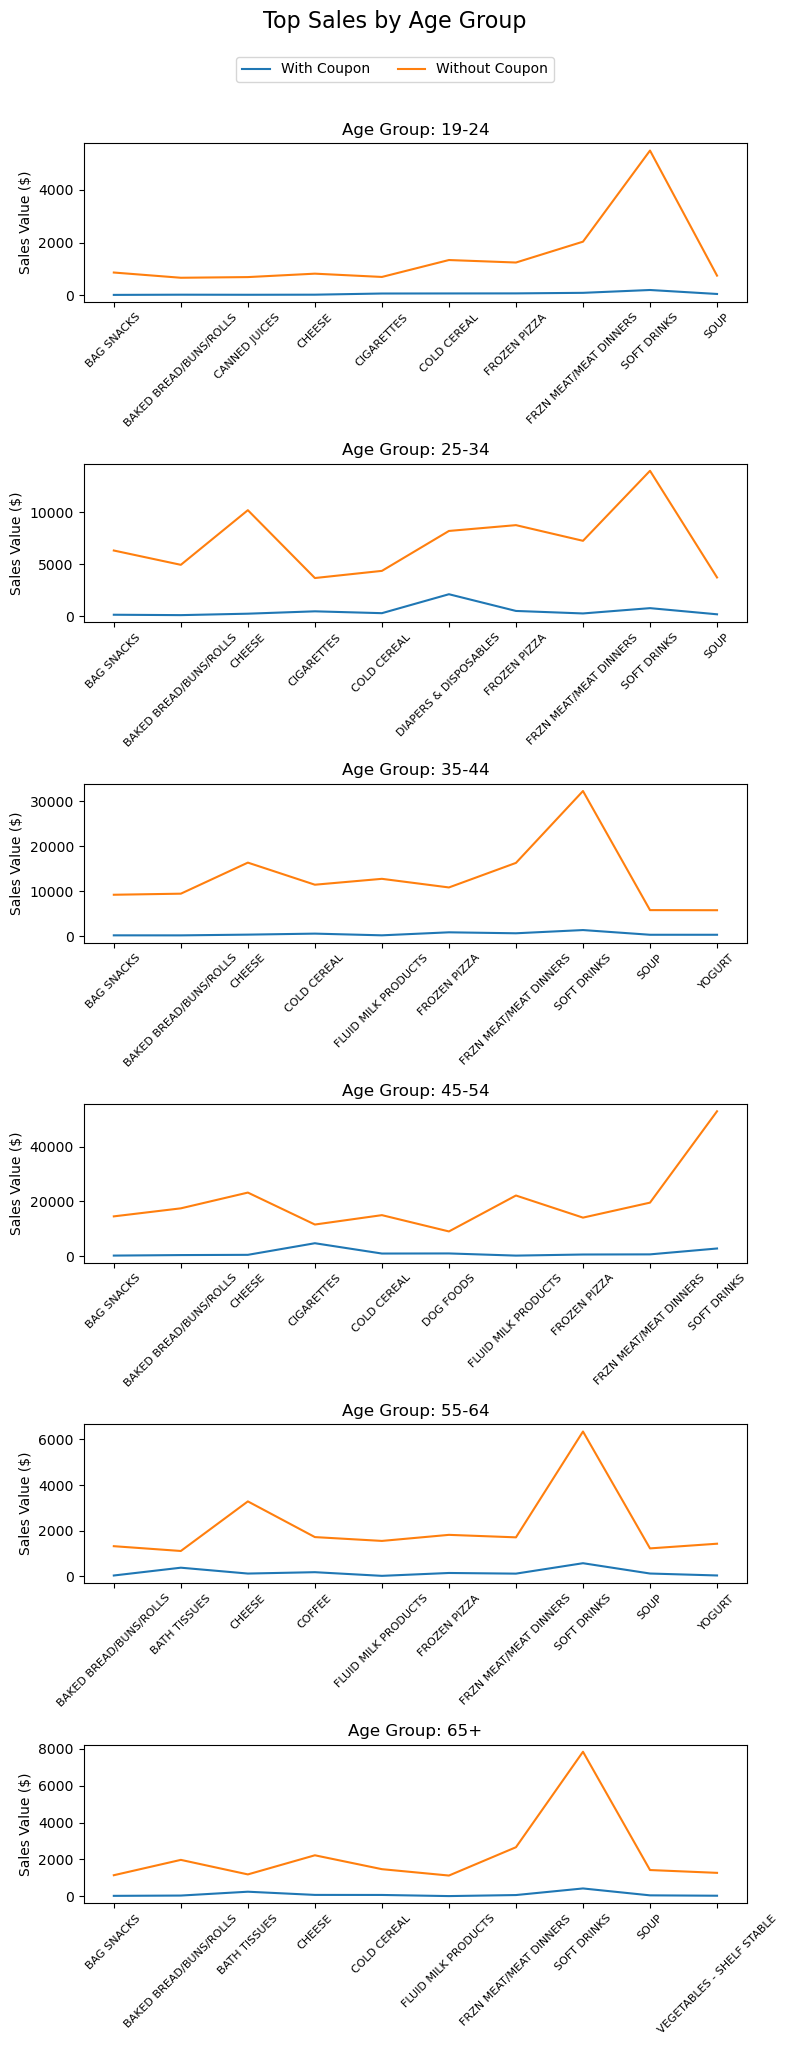

In [99]:
# Identify unique age groups
age_groups = merged_data['age_desc'].unique()

fig, axs = plt.subplots(len(age_groups), figsize=(8, 20))

for index, age_group in enumerate(age_groups):
    group_data = merged_data[merged_data['age_desc'] == age_group]
    group_data = group_data.groupby('commodity_desc').sum().reset_index()
    group_data['total_sales_value'] = group_data['sales_value_with_coupon'] + group_data['sales_value_without_coupon']
    top_10_commodities = group_data.nlargest(10, 'total_sales_value')['commodity_desc']
    top_10_data = group_data[group_data['commodity_desc'].isin(top_10_commodities)]
    
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_with_coupon'], label='With Coupon')
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_without_coupon'], label='Without Coupon')
    axs[index].set_title(f'Age Group: {age_group}')
    axs[index].set_ylabel('Sales Value ($)')

    # Rotate x-axis labels and make them smaller
    for tick in axs[index].get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(8)
        
        
# Place a legend at the top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.03))

fig.suptitle('Top Sales by Age Group', y=1.05, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 1.02])
plt.show()


<b>NOTES</b>: 
* Sales across all categories are higher for coupon sales. 
* Note the scale: ages 45-54 spent the most overall by  wide margin, followed by 35-44, including sales without coupons. This indicates that focusing on these age groups would be an efficient way to boost sales.
* For ALL age groups, soft drinks had the highest sales for coupons, but sales across categories were fairly flat for sales without coupons. This indicates that if there is a coupon for sodas, customers are likely to use it and buy soda when they wouldn’t otherwise, and is a good area to focus on for coupons across ages. 
* For all groups aside from the 19-24 year olds, there is also a peak for cheese purchases compared to non-coupon purchases. 
* For 25-34 year olds, there were peaks for diapers & disposables as well as frozen pizza. 


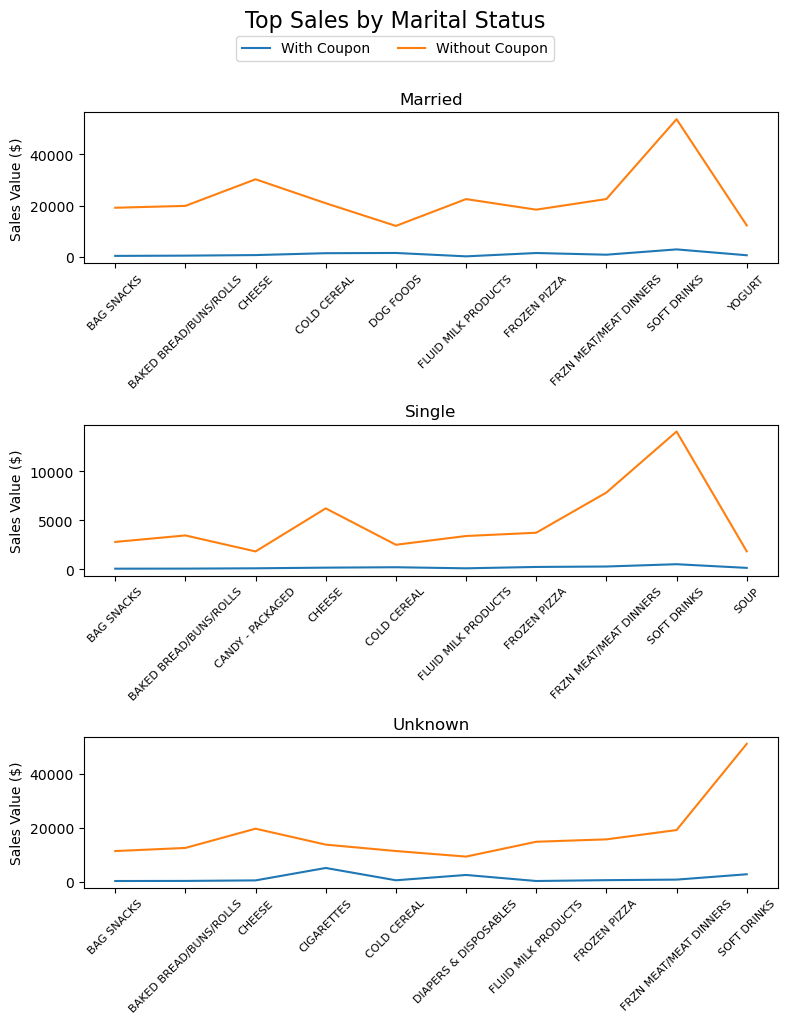

In [100]:
# Identify unique marriage groups
marriage_groups = merged_data['marital_status'].unique()

fig, axs = plt.subplots(len(marriage_groups), figsize=(8, 10))

for index, marriage_group in enumerate(marriage_groups):
    group_data = merged_data[merged_data['marital_status'] == marriage_group]
    group_data = group_data.groupby('commodity_desc').sum().reset_index()
    group_data['total_sales_value'] = group_data['sales_value_with_coupon'] + group_data['sales_value_without_coupon']
    top_10_commodities = group_data.nlargest(10, 'total_sales_value')['commodity_desc']
    top_10_data = group_data[group_data['commodity_desc'].isin(top_10_commodities)]
    
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_with_coupon'], label='With Coupon')
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_without_coupon'], label='Without Coupon')
    axs[index].set_title(f'{marriage_group}')
    axs[index].set_ylabel('Sales Value ($)')

    # Rotate x-axis labels and make them smaller
    for tick in axs[index].get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(8)
        
        
# Place a legend at the top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.03))

fig.suptitle('Top Sales by Marital Status', y=1.05, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 1.02])
plt.show()



<b>Notes</b>
* As with the age groups analysis, we see here that soft drinks are again the top coupon seller across marriage groups. 
* For all groups, the top 10 commodities sell much more with coupons than without.
* For all groups, cheese also sells much more with coupons. 
* Married and 'Unknown' households spend about 4x as much as single households. 
* Married households purchase a lot more dog food, but there's no major impact of coupons.

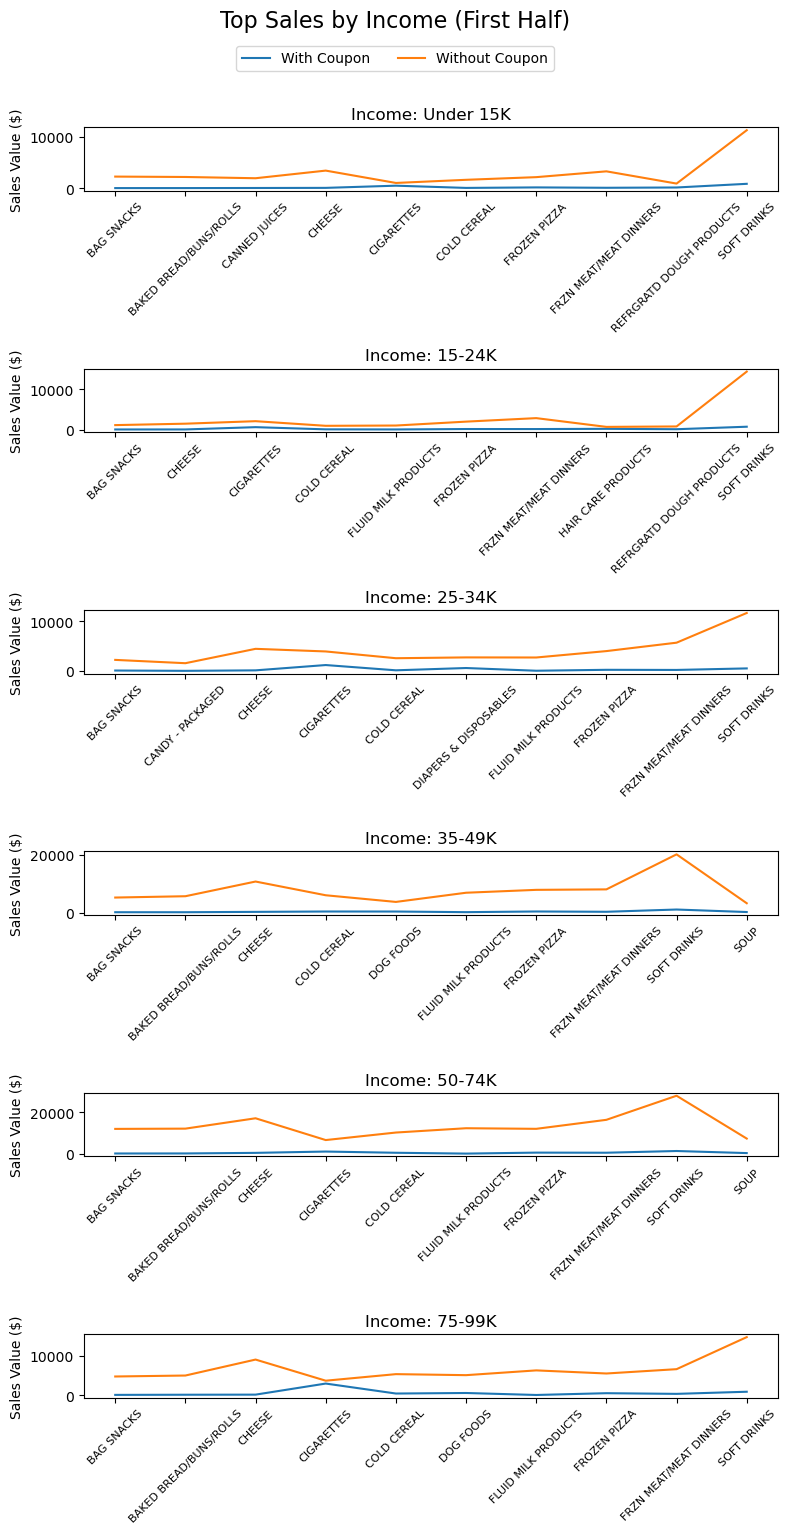

In [101]:
# NOTE: I was running into errors trying to do this in one code block, so splitting it in 2. 

income_order = ['Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', '75-99K', '100-124K', '125-149K', '150-174K', '175-199K', '200-249K', '250K+']
income_groups = sorted(merged_data['income_desc'].unique(), key=lambda x: income_order.index(x))

# Take the first half of the sorted income groups
first_half = income_groups[:len(income_groups)//2]

fig1, axs1 = plt.subplots(len(first_half), figsize=(8, 15))

for index, income_group in enumerate(first_half):
    group_data = merged_data[merged_data['income_desc'] == income_group]
    group_data = group_data.groupby('commodity_desc').sum().reset_index()
    group_data['total_sales_value'] = group_data['sales_value_with_coupon'] + group_data['sales_value_without_coupon']
    top_10_commodities = group_data.nlargest(10, 'total_sales_value')['commodity_desc']
    top_10_data = group_data[group_data['commodity_desc'].isin(top_10_commodities)]

    axs1[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_with_coupon'], label='With Coupon')
    axs1[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_without_coupon'], label='Without Coupon')
    axs1[index].set_title(f'Income: {income_group}')
    axs1[index].set_ylabel('Sales Value ($)')

    for tick in axs1[index].get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(8)

handles, labels = axs1[0].get_legend_handles_labels()
fig1.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.03))
fig1.suptitle('Top Sales by Income (First Half)', y=1.05, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 1.02])
plt.show()


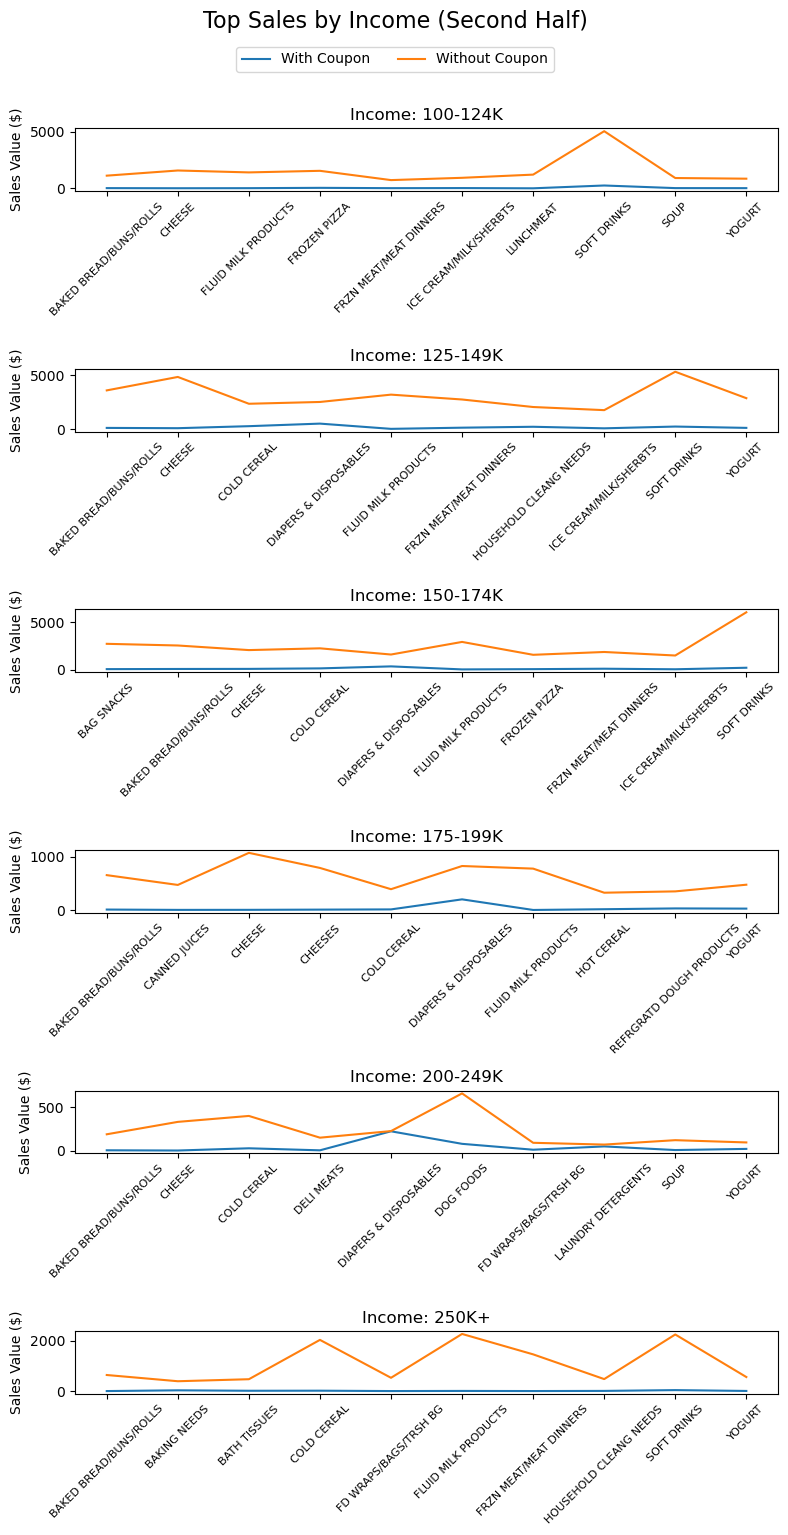

In [102]:
# Take the second half of the sorted income groups
second_half = income_groups[len(income_groups)//2:]

fig2, axs2 = plt.subplots(len(second_half), figsize=(8, 15))

for index, income_group in enumerate(second_half):
    group_data = merged_data[merged_data['income_desc'] == income_group]
    group_data = group_data.groupby('commodity_desc').sum().reset_index()
    group_data['total_sales_value'] = group_data['sales_value_with_coupon'] + group_data['sales_value_without_coupon']
    top_10_commodities = group_data.nlargest(10, 'total_sales_value')['commodity_desc']
    top_10_data = group_data[group_data['commodity_desc'].isin(top_10_commodities)]

    axs2[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_with_coupon'], label='With Coupon')
    axs2[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_without_coupon'], label='Without Coupon')
    axs2[index].set_title(f'Income: {income_group}')
    axs2[index].set_ylabel('Sales Value ($)')

    for tick in axs2[index].get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(8)

handles, labels = axs2[0].get_legend_handles_labels()
fig2.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.03))
fig2.suptitle('Top Sales by Income (Second Half)', y=1.05, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 1.02])
plt.show()


<b>Notes:</b>
* Income groups under 24K had a low usage of coupons, except for soft drinks. 
* 35-74K earners spent the most compared to other groups.
* Coupons for cheese had big responses for incomes: 35-49K, 50-74K, 75-99K, 125-149K, 175-199K, 
* Soft drinks did NOT make the top 10 purchases for incomes 175-199K and 200-249K, but reappeared for those with incomes higher than $250K. 
* Customers who make 200-249K spent the most on dog food using coupons. 


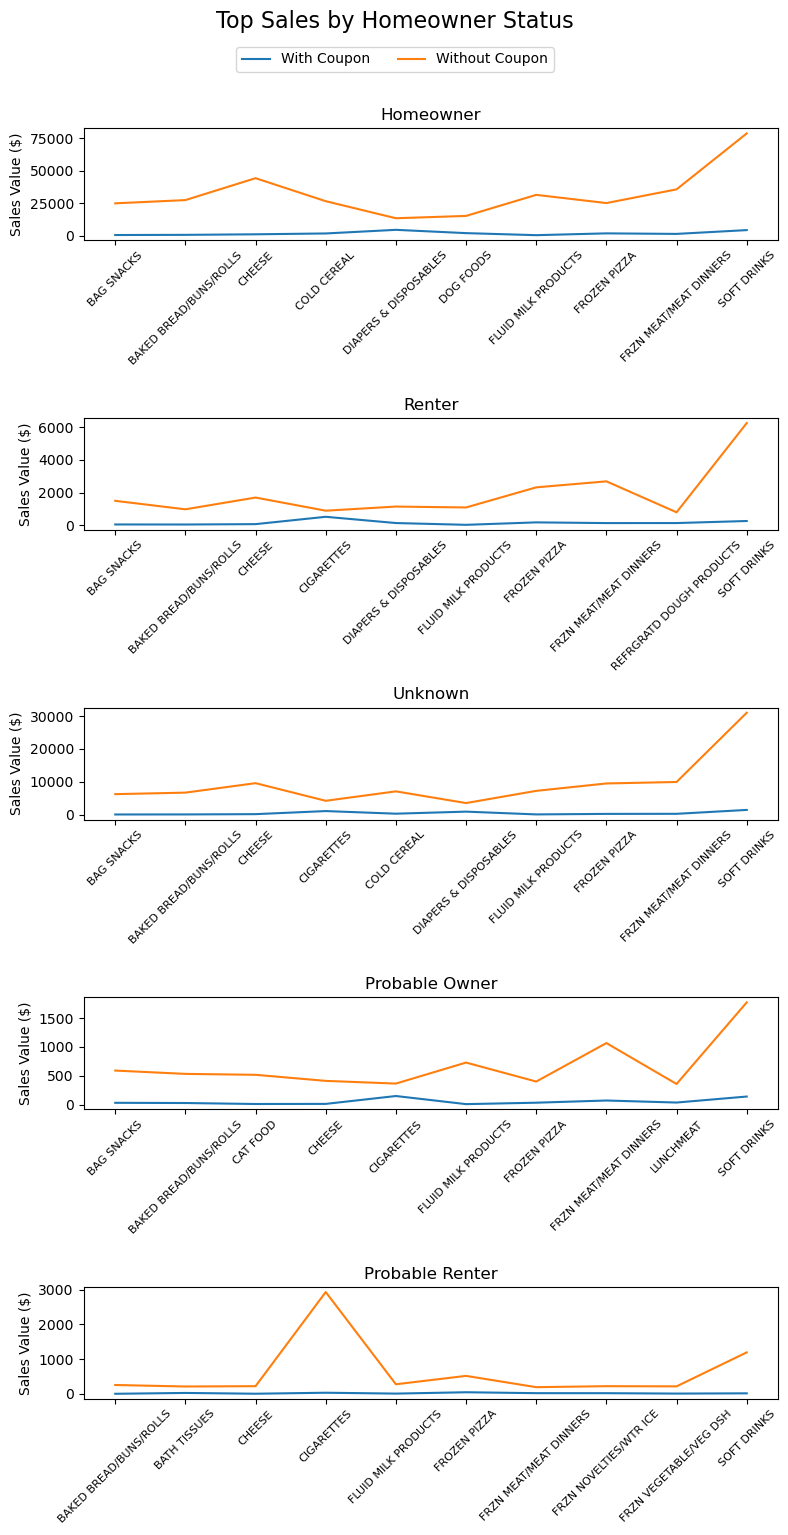

In [103]:
# Identify unique homeowner groups
homeowner_groups = merged_data['homeowner_desc'].unique()

fig, axs = plt.subplots(len(homeowner_groups), figsize=(8,15))

for index, homeowner_group in enumerate(homeowner_groups):
    group_data = merged_data[merged_data['homeowner_desc'] == homeowner_group]
    group_data = group_data.groupby('commodity_desc').sum().reset_index()
    group_data['total_sales_value'] = group_data['sales_value_with_coupon'] + group_data['sales_value_without_coupon']
    top_10_commodities = group_data.nlargest(10, 'total_sales_value')['commodity_desc']
    top_10_data = group_data[group_data['commodity_desc'].isin(top_10_commodities)]
    
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_with_coupon'], label='With Coupon')
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_without_coupon'], label='Without Coupon')
    axs[index].set_title(f'{homeowner_group}')
    axs[index].set_ylabel('Sales Value ($)')

    # Rotate x-axis labels and make them smaller
    for tick in axs[index].get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(8)
        
        
# Place a legend at the top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.03))

fig.suptitle('Top Sales by Homeowner Status', y=1.05, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 1.02])
plt.show()


<b>Notes: </b>
* Here is the first big change so far: probable renters are much more likely to use coupons for cigarettes than anything else, but overall much less likely to much coupons in general than any other groups we've seen.
* Homeowners purchase more cheese with coupons.
* Everyone purchases more soft drinks with coupons.
* Homeowners make up the vast majority of sales.

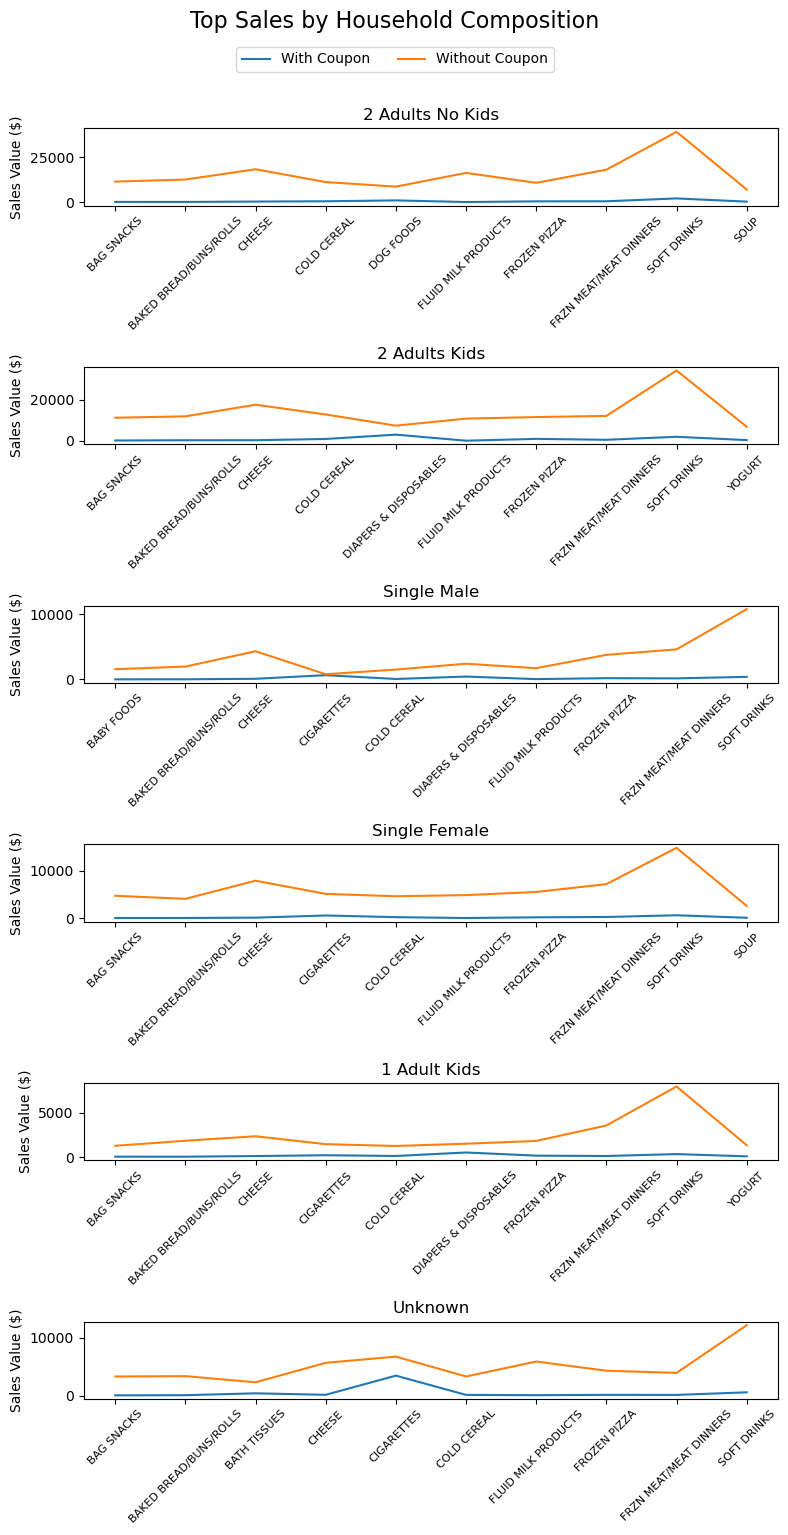

In [104]:
# Identify unique hh_comp groups
hh_comp_groups = merged_data['hh_comp_desc'].unique()

fig, axs = plt.subplots(len(hh_comp_groups), figsize=(8,15))

for index, hh_comp_group in enumerate(hh_comp_groups):
    group_data = merged_data[merged_data['hh_comp_desc'] == hh_comp_group]
    group_data = group_data.groupby('commodity_desc').sum().reset_index()
    group_data['total_sales_value'] = group_data['sales_value_with_coupon'] + group_data['sales_value_without_coupon']
    top_10_commodities = group_data.nlargest(10, 'total_sales_value')['commodity_desc']
    top_10_data = group_data[group_data['commodity_desc'].isin(top_10_commodities)]
    
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_with_coupon'], label='With Coupon')
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_without_coupon'], label='Without Coupon')
    axs[index].set_title(f'{hh_comp_group}')
    axs[index].set_ylabel('Sales Value ($)')

    # Rotate x-axis labels and make them smaller
    for tick in axs[index].get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(8)
        
        
# Place a legend at the top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.03))

fig.suptitle('Top Sales by Household Composition', y=1.05, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 1.02])
plt.show()


<b>Notes:</b> 
* As with most of what we've seen so far, soft drinks are univerally the top sales category for coupon use.
* 'Unknown' groups are more likely to purchase cigarettes in general, but doesn't seem to be impacted too much by coupon use. 
* Single males don't use coupons very much except for cheese, frozen pizza, frozen dinner and soft drinks
* 2 adult households (with kids and without) spend the most, however as these values are right around double what single people spend, it's reasonable to say that most households spend about the same amount per person. The exception to this is the single parent households, which spend about half as much.

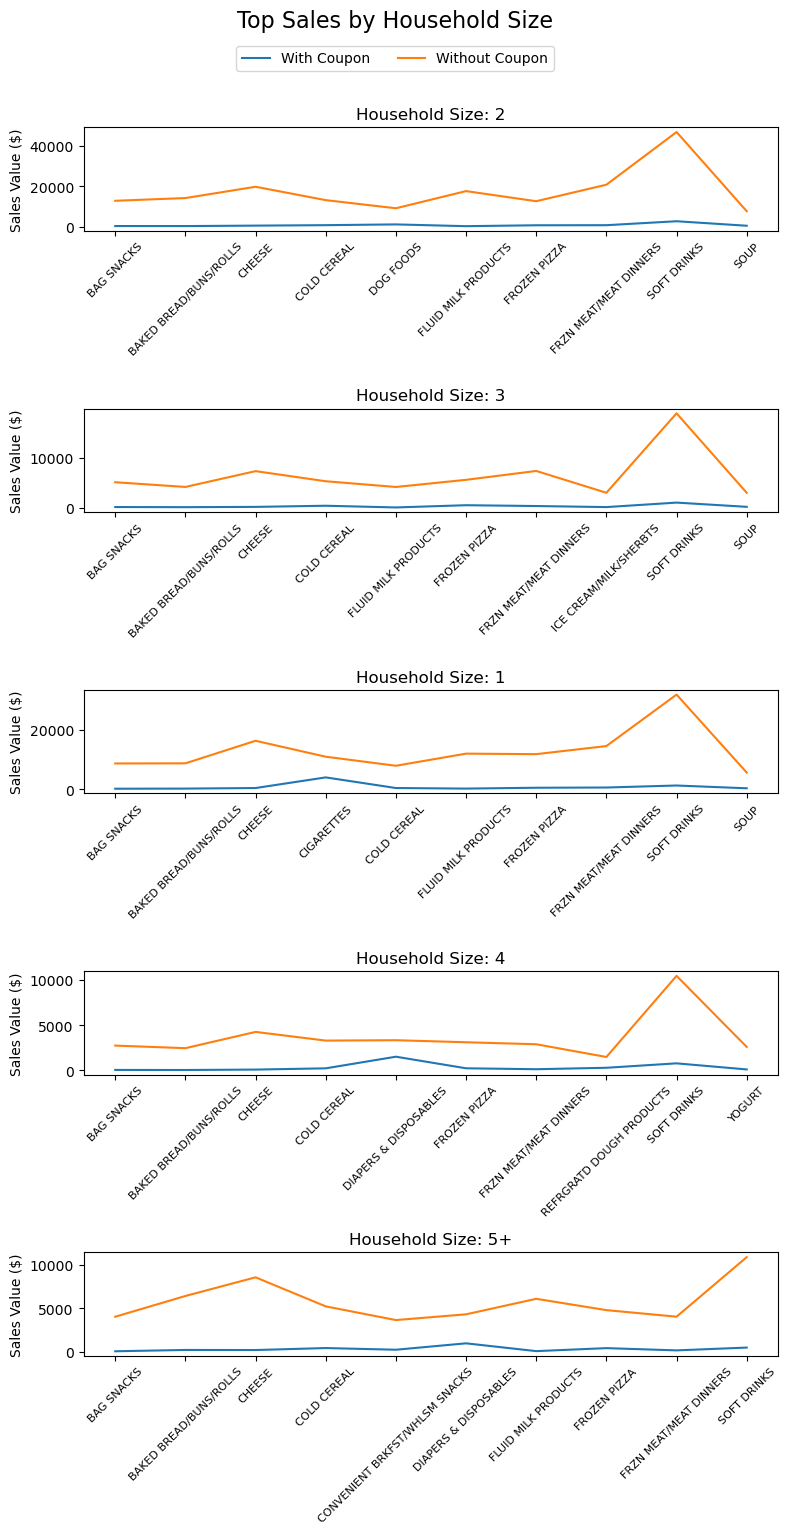

In [105]:
# Identify unique household_size groups
household_size_groups = merged_data['household_size_desc'].unique()

fig, axs = plt.subplots(len(household_size_groups), figsize=(8,15))

for index, household_size_group in enumerate(household_size_groups):
    group_data = merged_data[merged_data['household_size_desc'] == household_size_group]
    group_data = group_data.groupby('commodity_desc').sum().reset_index()
    group_data['total_sales_value'] = group_data['sales_value_with_coupon'] + group_data['sales_value_without_coupon']
    top_10_commodities = group_data.nlargest(10, 'total_sales_value')['commodity_desc']
    top_10_data = group_data[group_data['commodity_desc'].isin(top_10_commodities)]
    
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_with_coupon'], label='With Coupon')
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_without_coupon'], label='Without Coupon')
    axs[index].set_title(f'Household Size: {household_size_group}')
    axs[index].set_ylabel('Sales Value ($)')

    # Rotate x-axis labels and make them smaller
    for tick in axs[index].get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(8)
        
        
# Place a legend at the top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.03))

fig.suptitle('Top Sales by Household Size', y=1.05, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 1.02])
plt.show()

<b>Notes:</b> 
* As with the other groups, customers spend the most on soft drinks with coupons.
* Households with 5+ people use coupons at the highest rates, and also purchase a lot of cheese, convenient breakfast/snacks, bread, and diapers with coupons. 

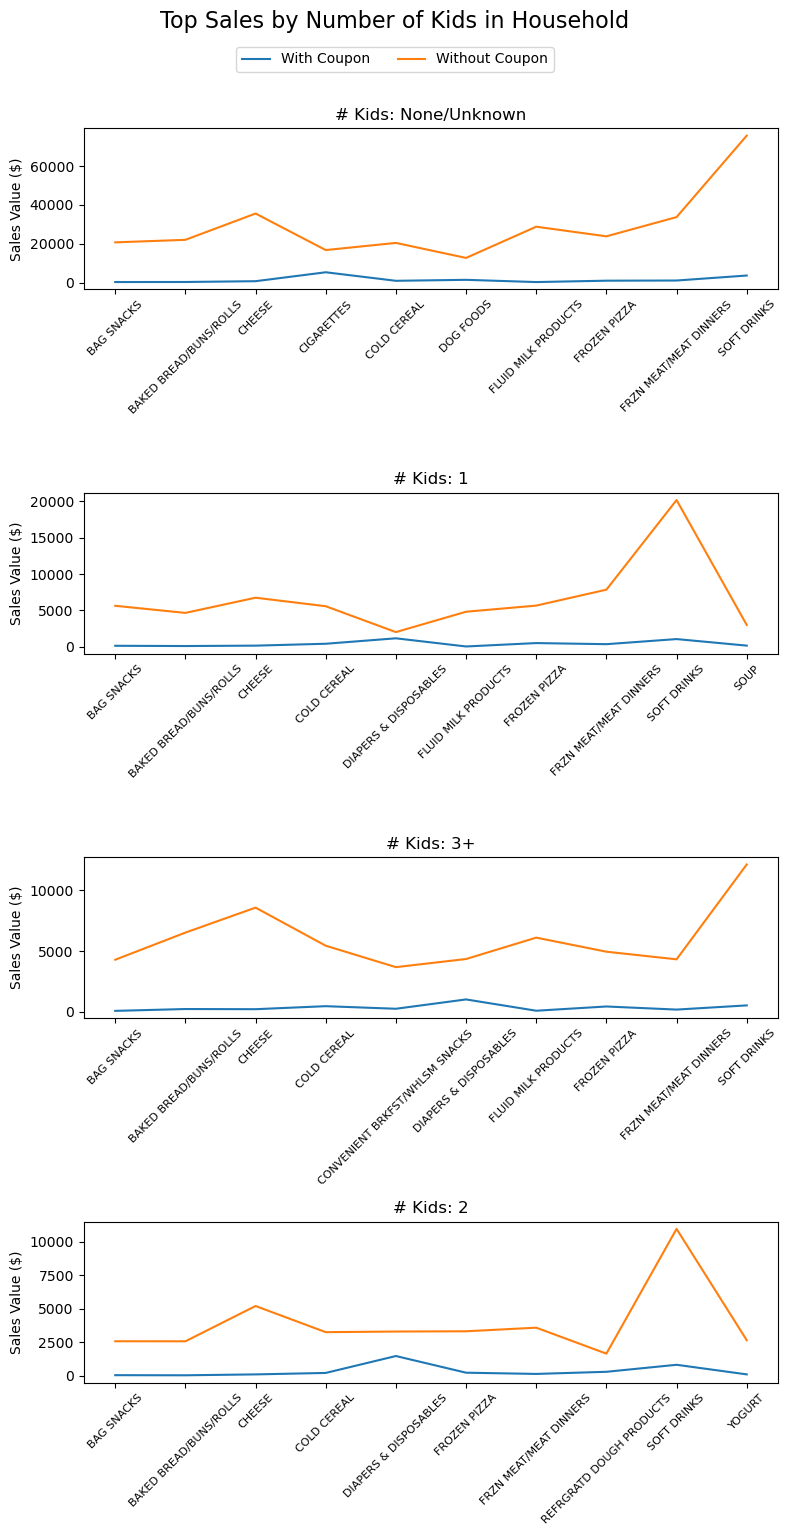

In [106]:
# Identify unique kid groups
kid_groups = merged_data['kid_category_desc'].unique()

fig, axs = plt.subplots(len(kid_groups), figsize=(8,15))

for index, kid_group in enumerate(kid_groups):
    group_data = merged_data[merged_data['kid_category_desc'] == kid_group]
    group_data = group_data.groupby('commodity_desc').sum().reset_index()
    group_data['total_sales_value'] = group_data['sales_value_with_coupon'] + group_data['sales_value_without_coupon']
    top_10_commodities = group_data.nlargest(10, 'total_sales_value')['commodity_desc']
    top_10_data = group_data[group_data['commodity_desc'].isin(top_10_commodities)]
    
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_with_coupon'], label='With Coupon')
    axs[index].plot(top_10_data['commodity_desc'], top_10_data['sales_value_without_coupon'], label='Without Coupon')
    axs[index].set_title(f'# Kids: {kid_group}')
    axs[index].set_ylabel('Sales Value ($)')

    # Rotate x-axis labels and make them smaller
    for tick in axs[index].get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontsize(8)
        
        
# Place a legend at the top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.03))

fig.suptitle('Top Sales by Number of Kids in Household', y=1.05, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 1.02])
plt.show()

<b>Notes:</b> 
* As with other groups, coupons are used mostly for soft drinks.
* All groups buy more cheese with coupons, especially families with 3+ kids.

### 1.6.4 Seasonal Patterns & Trends  <a id='1.6.4'></a>

In this section, I will inspect the data to see if I can detect obvious sales trends, look at seasonality, and create an ARIMA model.

<b>Make a time series plot to see if there are weekly sales patterns</b>

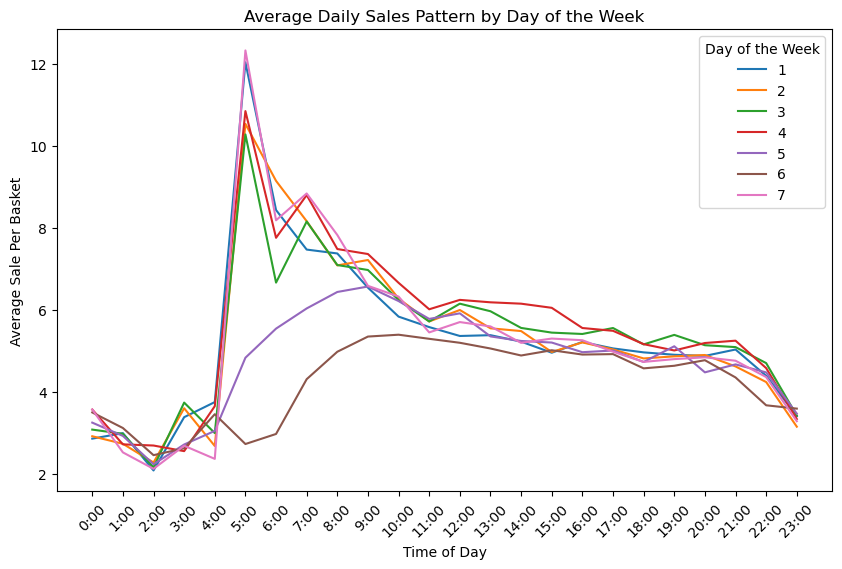

In [107]:
# Convert 'trans_time' to datetime format - this changed somewhere
transaction_data['trans_time'] = pd.to_datetime(transaction_data['trans_time']).dt.time

transaction_data['day_of_week'] = transaction_data['day'] % 7 

transaction_data['hour'] = transaction_data['trans_time'].apply(lambda x: x.hour)

average_sales = transaction_data.groupby(['day_of_week', 'hour','basket_id'])['sales_value'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='sales_value', hue='day_of_week', data=average_sales, palette='tab10', errorbar=None)
plt.xlabel('Time of Day')
plt.ylabel('Average Sale Per Basket')
plt.title('Average Daily Sales Pattern by Day of the Week')
plt.xticks(ticks=range(24), labels=[f'{hour}:00' for hour in range(24)], rotation=45)
plt.legend(title='Day of the Week', labels=[str(i) for i in range(1, 8)])
plt.show()


Based on the above plot, I'm pretty sure that days 5 and 6 are Saturday & Sunday, but I will leave the days as numbers. We can see clear daily patterns in purchases.

<b>Are there seasonal trends?</b>

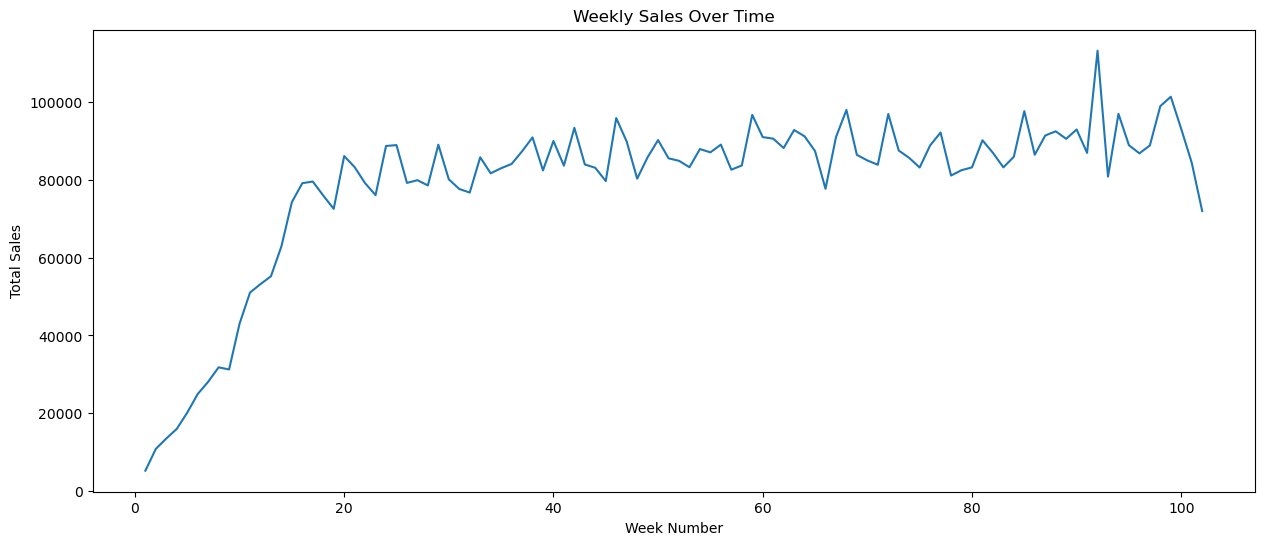

In [108]:
# Aggregate sales by week:
weekly_sales = transaction_data.groupby('week_no')['sales_value'].sum().reset_index()

# Plot weekly sales over time
plt.figure(figsize=(15, 6))
plt.plot(weekly_sales['week_no'], weekly_sales['sales_value'])
plt.xlabel('Week Number')
plt.ylabel('Total Sales')
plt.title('Weekly Sales Over Time')
plt.show();

<b>We have been seeing a distinct elbow around 20 weeks. I want to see how many campaigns are active over time to see if the answer is there.</b>

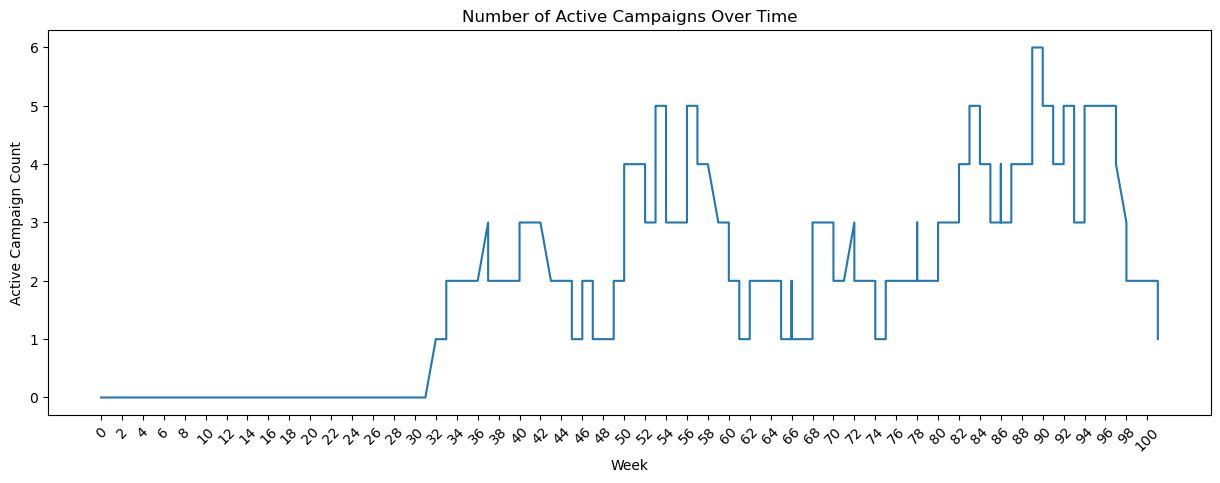

In [109]:
# Create list of all days and weeks
all_days = list(range(1, 712))
all_weeks = [day // 7 for day in all_days]

active_campaigns = []

for day in all_days:
    active_count = campaign_desc[(campaign_desc['start_day'] <= day) & (campaign_desc['end_day'] >= day)].shape[0]
    active_campaigns.append(active_count)

plt.figure(figsize=(15, 5))
plt.plot(all_weeks, active_campaigns)
plt.xlabel('Week')
plt.ylabel('Active Campaign Count')
plt.title('Number of Active Campaigns Over Time')

plt.xticks(range(min(all_weeks), max(all_weeks) + 1, 2), rotation=45)

plt.show()


In [110]:
campaign_desc.start_day.sort_values().tail()

6    624
5    624
4    646
2    659
0    659
Name: start_day, dtype: int64

This is interesting - the campaigns were only sent out starting on day 224 (week 32), and ending on day 659 (week 94). 

It could be helpful to compare total sales during the times there were no active campaigns and compare to when there were. 

Why did sales go up to a stable-ish place around 20 weeks, when campaigns weren't sent until 32 weeks? 

<b> Is the data stationary?</b>

In [111]:
# Following method here: https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjdjMGI2OTEzZmUxMzgyMGEzMzMzOTlhY2U0MjZlNzA1MzVhOWEwYmYiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDI5MzM3MjkwOTIzMjcyMjg2MzUiLCJlbWFpbCI6ImFubmllZXJic2VucHJvamVjdHNAZ21haWwuY29tIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsIm5iZiI6MTY5NTQwNjI2OCwibmFtZSI6IkFubmllIEVyYnNlbiIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS9BQ2c4b2NLME9qVlh6UEV6aGtWTU1Ydi05WC1qRnpCUTdXaDRCVU95NzJ5MDU3WWw9czk2LWMiLCJnaXZlbl9uYW1lIjoiQW5uaWUiLCJmYW1pbHlfbmFtZSI6IkVyYnNlbiIsImxvY2FsZSI6ImVuIiwiaWF0IjoxNjk1NDA2NTY4LCJleHAiOjE2OTU0MTAxNjgsImp0aSI6IjY3NjY4NTgyZGUwYzBiNmRiN2EzNzcwZmNhNTAzMjY0YjgyMzQxMzkifQ.c-t03_fkjo-4F_QmaefgqgIXit_2I7yfYAJfTHrGT7zlmi1gp7K1NyXbbKOKxBpnGpUes65zR4kb5nOH3LKxYvjEyEOoAhOfa0HpfacIe3MfoQUSzZy8rjNIe6rTpHxUHRy3s-tdUa1paRcnt5dLrhAkoqBUB4OJzD8dlBHe6NrUVmCbWLQBxp1bjL2lb8vBT1jPagaVSNL5-GCKvpBpHufIOxkb3XPXc8SocHpfiBr8JJ2xYZeBvxVzoTdLl-TXxXIGn2P-32PGISlF1JJD8Zyy3K-xFUDXGGhvy-wRSPoqh1iNB0DHEaB8R_ubogRHcgOG-wjT9BeCJ5AoxK0ELw

# Do a KPSS test - if the p value is < 0.05, we can reject the null hypothesis that our data is stationary. 
result = kpss(weekly_sales['sales_value'])
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')

KPSS Statistic: 0.9695887050934676
p-value: 0.01


C:\Users\leann\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [112]:
# Ad Fuller test- if p value < 0.05, we can reject the null hypothesis that the data is not stationary.
result = adfuller(weekly_sales['sales_value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -5.205598515138894
p-value: 8.563619560458387e-06


<b>There are conflicting results here. </b> The Ad Fuller test says that the data is stationary, the KPSS test says it is not stationary.

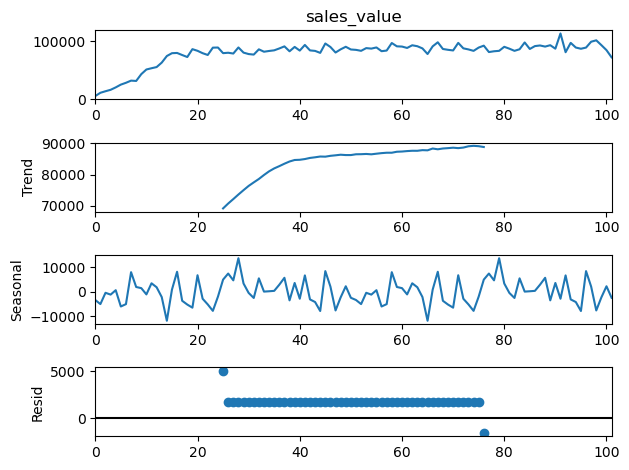

In [113]:
# Decompose to see if we can see anything here. NOTE: I can't get the period exactly right because there are not exactly 2 years

decomposition = seasonal_decompose(weekly_sales['sales_value'], model='additive', period=51)
decomposition.plot()
plt.show()

Our data doesn't appear to be stationary. There is an elbow in the trend, meaning that there was likely a change around this time. 

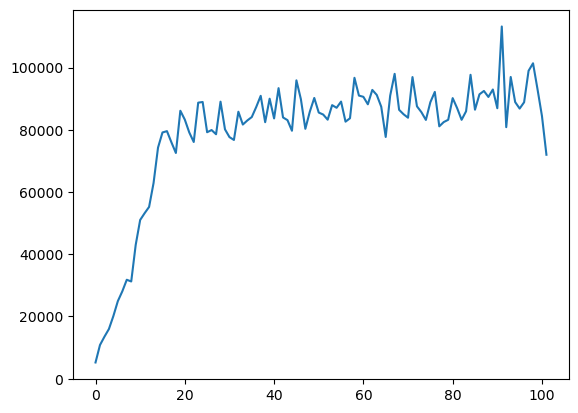

In [114]:
# Remove trend
weekly_sales["diff"] =  weekly_sales['sales_value'].diff()

ax = weekly_sales['sales_value'].plot()
plt.show;

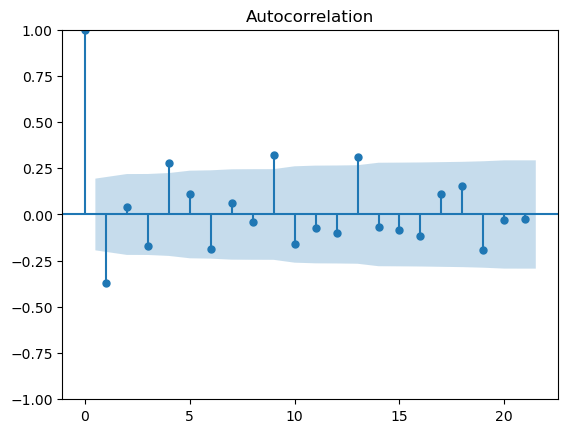

In [115]:
# Plot autocorrelation
weekly_sales.loc[weekly_sales.index[0], 'diff'] = 0
plot_acf(weekly_sales["diff"])
plt.show()

<b>The autocorrelation plot above indicates that there is some seasonality.</b> Investigating the significant lags and the time between them below to see if I can find a indication of a seasonal pattern. 

In [116]:
series = weekly_sales['sales_value']

acf_values = acf(series, nlags=102)  

confidence_level = 1.96
N = len(series)
confidence_interval = confidence_level / np.sqrt(N)

# Find lags where the ACF value is outside the confidence interval
significant_lags = np.where((acf_values > confidence_interval) | (acf_values < -confidence_interval))[0]

# Calculate distances between significant lags
distances = np.diff(significant_lags)

print("Significant lags:", significant_lags)
print("Distances between significant lags:", distances)


Significant lags: [ 0  1  2  3  4  5  6  7  8  9 10 11 84 85 86 87 88]
Distances between significant lags: [ 1  1  1  1  1  1  1  1  1  1  1 73  1  1  1  1]


<b>There is something seasonal happening around 84 weeks</b>

## 1.7 Exports <a id='1.7'></a>

In [117]:
campaign_desc.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\campaign_desc.csv", index=False)
campaign_table.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\campaign_table.csv", index=False)
coupon.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\coupon.csv", index=False)
coupon_redempt.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\coupon_redempt.csv", index=False)
hh_demographic.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\hh_demographic.csv", index=False)
product.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\product.csv", index=False)
transaction_data.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\transaction_data.csv", index=False)

# tables that I created
demo_coupon.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\demo_coupon", index=False)
demo_no_disc.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\demo_no_disc", index=False)
merged_data.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\merged_data", index=False)


## 1.8 Conclusions <a id='1.8'></a>

This data set consists of 8 tables: campaign_desc, campaign_table, causal_data, coupon, coupon_redempt, hh_demographic, product and transaction_data. The data tracks 2500 households over 51 weeks, 801 of which there is demographic data. There were 30 marketing campaigns mailed to these households, which ranged from 47-161 days long, and the campaigns were active from weeks 32 to 94. Although there were 30 campaigns, campaigns 18,13 and 8 were sent out to far more households than the others, and it follows that these had the greatest response counts. 

Upon inspecting how sales of products in certain categories are distributed among different demographics, I noticed that sales for the commodity type of ‘cheese’ appeared to change the most in response to coupons and demographics. Because of this, I would like to focus on the commodity_desc ‘cheese’ for the rest of this project, and build a model to determine how demographics, seasonality and coupons contribute to cheese sales, and predict future cheese sales. From this I will be able to make recommendations on what coupons should be sent to different demographics to maximize sales. 

<b>Data that I can drop</b>

* In the transaction_data table, I will drop amt_paid, retail_disc, and coupon_match_disc. I am only interested in the coupons that can be tracked through the direct marketing campaigns. I can also drop the time of day that a transaction occurred because I’m interested the total sales of a day or week; as coupons can be used any time of day, this is extraneous information. 

* In the interest of time and narrowing the scope of this project, I have decided to not use the causal_data table. It relates to information about what products are featured in in-store displays and in mailers, and I am focusing on direct marketing campaigns that consist of coupons mailed to households. 

* As I am interested in the coupons that apply to cheese products, I no longer need to look at the campaign numbers, so I can also drop the campaign_table table. I will keep the campaign_desc table because it includes data on when campaigns (and by extension, coupons) are active. 







## 1.9 Next Steps <a id='1.9'></a>

I will continue with pre-processing and baseline modeling in the next notebook, titled '2 Dunnhumby- Pre-processing and Baseline Modeling'